In [1]:
import json, os, torch, cv2, random, numpy as np, albumentations as A, nibabel as nib
from matplotlib import pyplot as plt; from glob import glob;
from torch.utils.data import random_split, Dataset, DataLoader
from albumentations.pytorch import ToTensorV2; from PIL import Image
from torchvision import transforms as tfs

class CustomSegmentationDataset(Dataset):
    
    def __init__(self, root, transformations = None):

        im_nii_paths = sorted(glob(f"{root}/images/*.nii"))
        label_nii_paths = sorted(glob(f"{root}/labels/*.nii"))  # Assuming both liver and tumor labels are in the same directory
        
        self.ims, self.labels = self.get_slices(im_nii_paths, label_nii_paths)
        self.transformations = transformations
        self.n_cls = 3  # Liver, Tumor, Background
        
        assert len(self.ims) == len(self.labels)
        
    def __len__(self): return len(self.ims)

    def __getitem__(self, idx):
        
        im, label = self.ims[idx], self.labels[idx]
        if self.transformations: 
            im, label = self.apply_transformations(im, label)
        
        # For visualization purposes
        im = self.preprocess_im(im)
        
        return im.float(), label.long()
        
    def preprocess_im(self, im): 
        max_val = torch.max(im)
        im[im < 0] = 0
        return im / max_val
    
    def get_slices(self, im_nii_paths, label_nii_paths): 
        
        ims, labels = [], []
        
        for index, (im_nii, label_nii) in enumerate(zip(im_nii_paths, label_nii_paths)):
            if index == 50: break
            print(f"nifti file number {index + 1} is being converted...")
            nii_im_data, nii_label_data = self.read_nii(im_nii, label_nii)
            
            for idx, (im, label) in enumerate(zip(nii_im_data, nii_label_data)):
                if len(np.unique(label)) == 3:  # Assuming label values are 0, 1, and 2 for background, liver, and tumor
                    ims.append(im); labels.append(label)
        
        return ims, labels

    def read_nii(self, im, label): 
        return (
            nib.load(im).get_fdata().transpose(2, 1, 0), 
            nib.load(label).get_fdata().transpose(2, 1, 0)
        )
    
    def apply_transformations(self, im, label): 
        transformed = self.transformations(image = im, mask = label)
        return transformed["image"], transformed["mask"]

def get_dls(root, transformations, bs, split = [0.9, 0.05, 0.05], ns = 4):
        
    assert sum(split) == 1., "Sum of the split must be exactly 1"
    
    ds = CustomSegmentationDataset(root = root, transformations = transformations)
    n_cls = ds.n_cls
    
    tr_len = int(len(ds) * split[0])
    val_len = int(len(ds) * split[1])
    test_len = len(ds) - (tr_len + val_len)
    
    # Data split
    tr_ds, val_ds, test_ds = torch.utils.data.random_split(ds, [tr_len, val_len, test_len])
        
    print(f"\nThere are {len(tr_ds)} number of images in the train set")
    print(f"There are {len(val_ds)} number of images in the validation set")
    print(f"There are {len(test_ds)} number of images in the test set\n")
    
    # Get dataloaders
    tr_dl  = DataLoader(dataset = tr_ds, batch_size = bs, shuffle = True, num_workers = ns, drop_last=True)
    val_dl = DataLoader(dataset = val_ds, batch_size = bs, shuffle = False, num_workers = ns, drop_last=True)
    test_dl = DataLoader(dataset = test_ds, batch_size = 1, shuffle = False, num_workers = ns, drop_last=True)
    
    return tr_dl, val_dl, test_dl, n_cls

root = "/kaggle/input/3d-liver-and-liver-tumor-segmentation/08-3D-Liver-Tumor-Segmentation/08-3D-Liver-Tumor-Segmentation/Task03_Liver_rs"
mean, std, im_h, im_w = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225], 256, 256
trans = A.Compose( [A.Resize(im_h, im_w), ToTensorV2(transpose_mask = True) ])
tr_dl, val_dl, test_dl, n_cls = get_dls(root = root, transformations = trans, bs = 16)

nifti file number 1 is being converted...
nifti file number 2 is being converted...
nifti file number 3 is being converted...
nifti file number 4 is being converted...
nifti file number 5 is being converted...
nifti file number 6 is being converted...
nifti file number 7 is being converted...
nifti file number 8 is being converted...
nifti file number 9 is being converted...
nifti file number 10 is being converted...
nifti file number 11 is being converted...
nifti file number 12 is being converted...
nifti file number 13 is being converted...
nifti file number 14 is being converted...
nifti file number 15 is being converted...
nifti file number 16 is being converted...
nifti file number 17 is being converted...
nifti file number 18 is being converted...
nifti file number 19 is being converted...
nifti file number 20 is being converted...
nifti file number 21 is being converted...
nifti file number 22 is being converted...
nifti file number 23 is being converted...
nifti file number 24

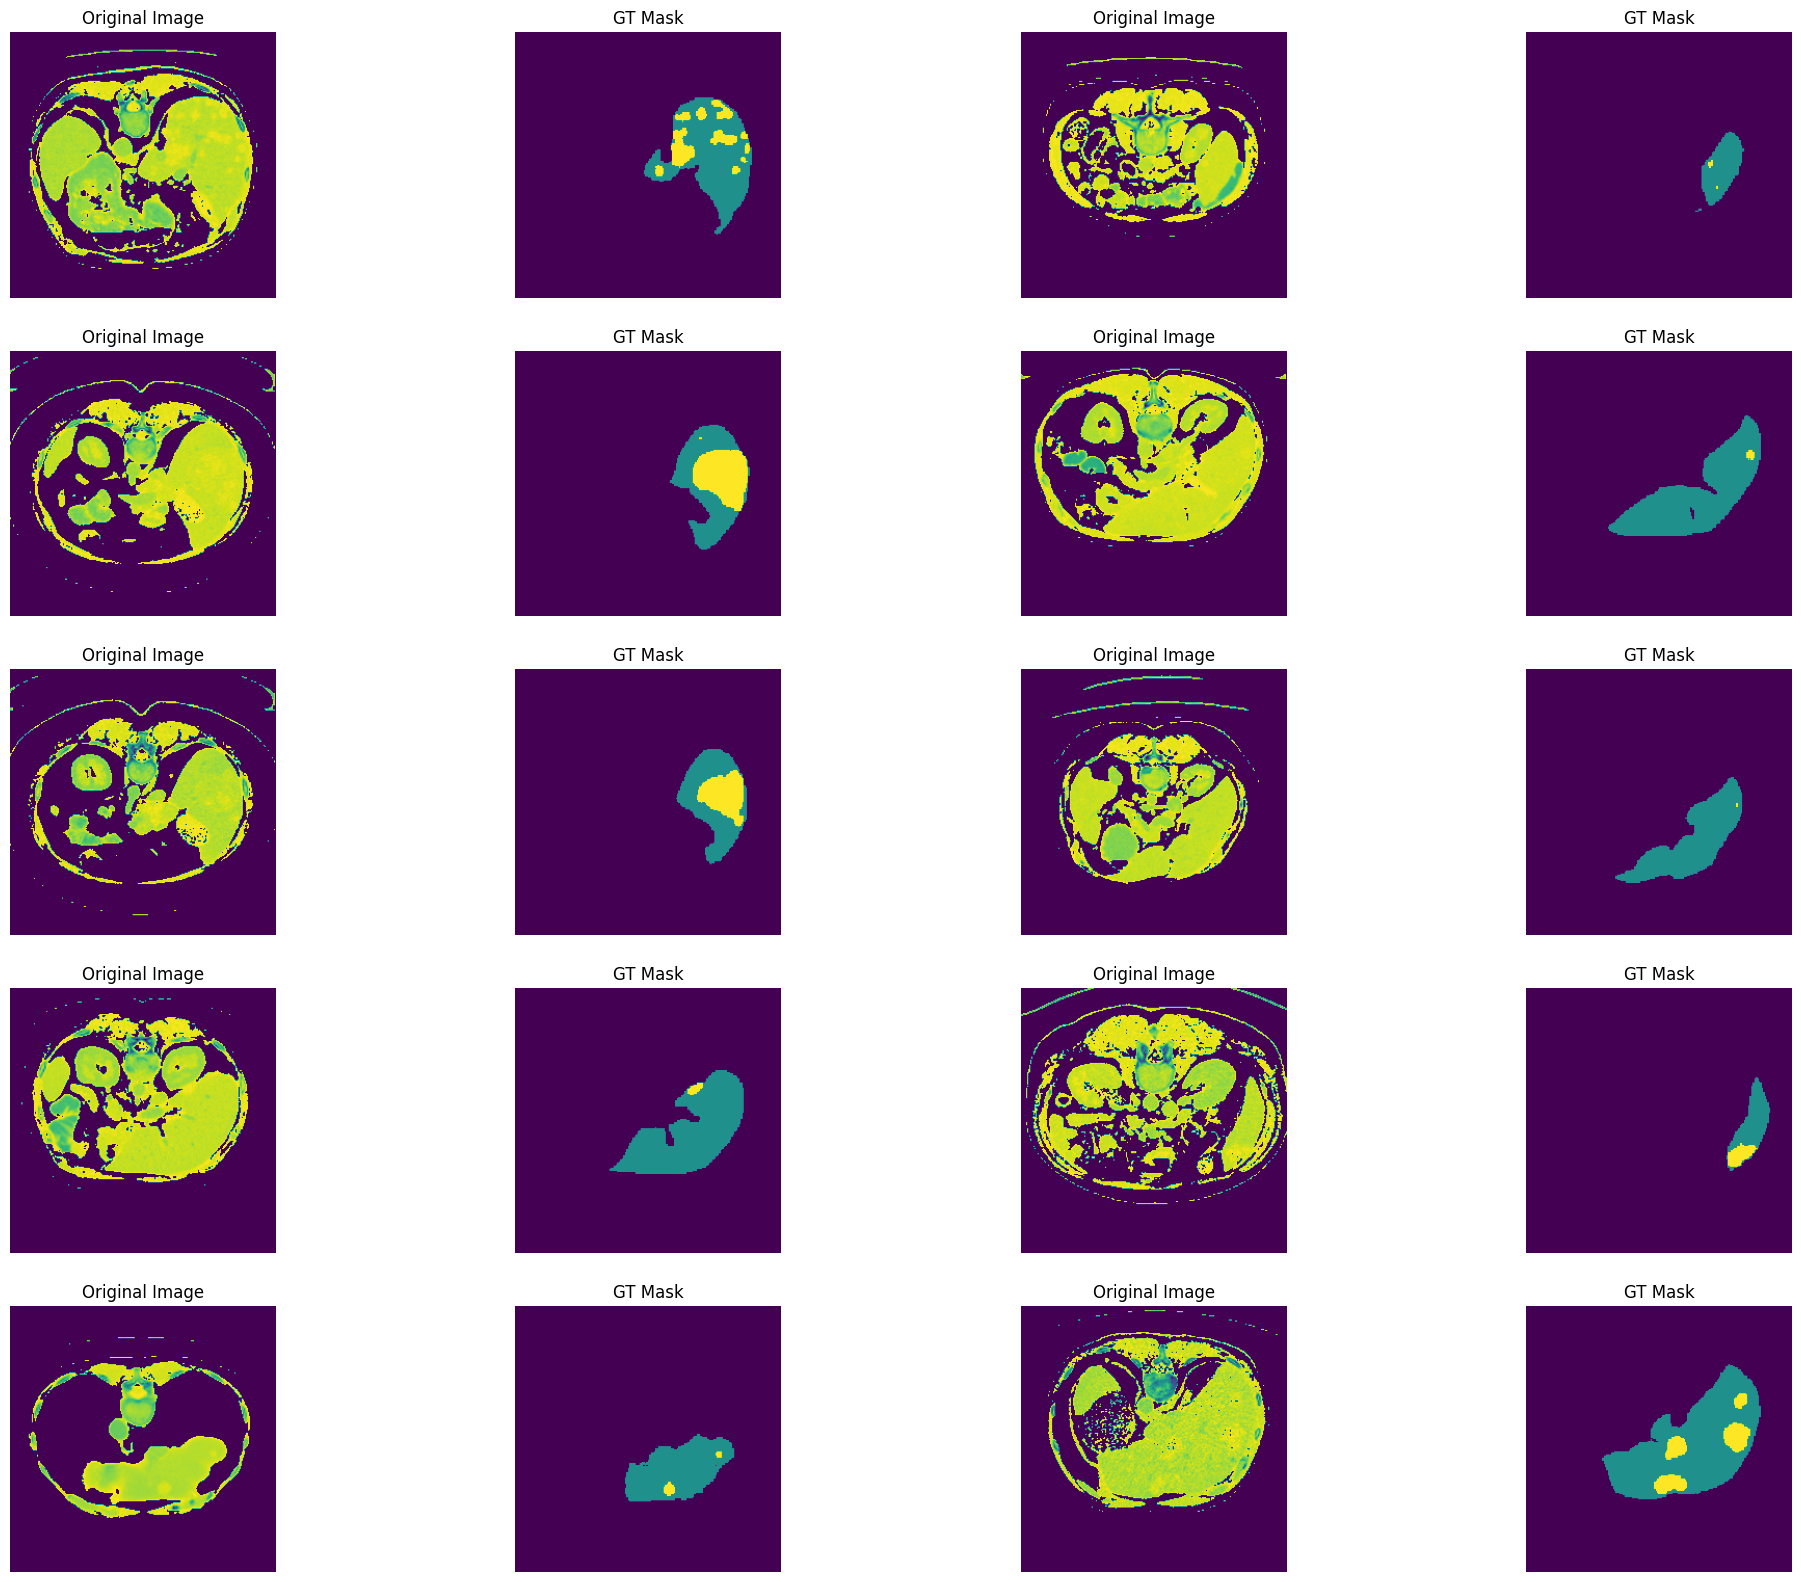

In [2]:
def plot(rows, cols, count, im, gt = None, title = "Original Image"):
    
    plt.subplot(rows, cols, count)
    plt.imshow(im.squeeze(0).float()) if gt else plt.imshow((im * 255).cpu().permute(1, 2, 0).numpy().astype("uint8") * 255)
    plt.axis("off"); plt.title(title)
    
    return count + 1

def visualize(ds, n_ims):
    
    plt.figure(figsize = (25, 20))
    rows = n_ims // 4; cols = n_ims // rows
    count = 1
    indices = [random.randint(0, len(ds) - 1) for _ in range(n_ims)]
    
    for idx, index in enumerate(indices):
        
        if count == n_ims + 1: break
        
        im, gt = ds[index]
    
        # First Plot
        count = plot(rows, cols, count, im = im)
        
        # Second Plot
        count = plot(rows, cols, count, im = gt.squeeze(0), gt = True, title = "GT Mask")
        
        
visualize(tr_dl.dataset, n_ims = 20)

# **Model Training**

In [4]:
!pip install segmentation_models_pytorch
import segmentation_models_pytorch as smp
import torch
import numpy as np
import time

# Define the number of classes
n_cls = 3  # Adjust this based on your number of classes

backbone = 'resnet50'  # Choose your desired backbone
model = smp.DeepLabV3Plus(
    encoder_name=backbone,
    encoder_weights='imagenet',
    in_channels=1,
    classes=n_cls,
)

# Define loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=3e-4)

class Metrics():
    def __init__(self, pred, gt, loss_fn, eps=1e-10, n_cls=3):
        self.pred, self.gt = torch.argmax(pred, dim=1), gt  # Adjust here based on your class dimension
        self.loss_fn, self.eps, self.n_cls, self.pred_ = loss_fn, eps, n_cls, pred

    def to_contiguous(self, inp): 
        return inp.contiguous().view(-1)

    def PA(self):
        with torch.no_grad():
            match = torch.eq(self.pred, self.gt).int()
        return float(match.sum()) / float(match.numel())

    def iou_score(self, pred, gt, c):
        match_pred = pred == c
        match_gt = gt == c
        if match_gt.long().sum().item() == 0:
            return np.nan
        else:
            intersect = torch.logical_and(match_pred, match_gt).sum().float().item()
            union = torch.logical_or(match_pred, match_gt).sum().float().item()
            iou = (intersect + self.eps) / (union + self.eps)
            return iou

    def mIoU(self):
        with torch.no_grad():
            pred, gt = self.to_contiguous(self.pred), self.to_contiguous(self.gt)
            iou_per_class = []
            for c in range(self.n_cls):
                iou_per_class.append(self.iou_score(pred, gt, c))
            return np.nanmean(iou_per_class)

    def iou_liver(self):
        with torch.no_grad():
            pred, gt = self.to_contiguous(self.pred), self.to_contiguous(self.gt)
            return self.iou_score(pred, gt, 1)  # Class 1 is assumed to be liver

    def iou_tumor(self):
        with torch.no_grad():
            pred, gt = self.to_contiguous(self.pred), self.to_contiguous(self.gt)
            return self.iou_score(pred, gt, 2)  # Class 2 is assumed to be tumor

    def loss(self): 
        return self.loss_fn(self.pred_, self.gt.squeeze(1))

def tic_toc(start_time=None): 
    return time.time() if start_time is None else time.time() - start_time

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 184MB/s] 


In [5]:
from tqdm import tqdm
def train(model, tr_dl, val_dl, test_dl, loss_fn, opt, device, epochs, save_prefix, threshold=0.005, save_path="saved_models"):
    
    tr_loss, tr_pa, tr_miou, tr_liver_iou, tr_tumor_iou = [], [], [], [], []
    val_loss, val_pa, val_miou, val_liver_iou, val_tumor_iou = [], [], [], [], []
    test_loss, test_pa, test_miou, test_liver_iou, test_tumor_iou = [], [], [], [], []
    tr_len, val_len, test_len = len(tr_dl), len(val_dl), len(test_dl)
    best_loss, decrease, not_improve, early_stop_threshold = np.inf, 1, 0, 5
    os.makedirs(save_path, exist_ok=True)

    model.to(device)
    train_start = time.time()
    print("Start training process...")
    
    for epoch in range(1, epochs + 1):
        tic = time.time()
        tr_loss_, tr_miou_, tr_pa_, tr_liver_iou_, tr_tumor_iou_ = 0, 0, 0, 0, 0
        
        model.train()
        print(f"Epoch {epoch} train process is started...")
        for idx, batch in enumerate(tqdm(tr_dl)):
            ims, gts = batch
            ims, gts = ims.to(device), gts.to(device).long()

            preds = model(ims)

            met = Metrics(preds, gts, loss_fn, n_cls=n_cls)
            loss_ = met.loss().requires_grad_()

            tr_miou_ += met.mIoU()
            tr_pa_ += met.PA()
            tr_liver_iou_ += met.iou_liver()
            tr_tumor_iou_ += met.iou_tumor()
            tr_loss_ += loss_.item()

            loss_.backward()
            opt.step()
            opt.zero_grad()
        
        print(f"Epoch {epoch} validation process is started...")
        model.eval()
        val_loss_, val_miou_, val_pa_, val_liver_iou_, val_tumor_iou_ = 0, 0, 0, 0, 0

        with torch.no_grad():
            for idx, batch in enumerate(tqdm(val_dl)):

                ims, gts = batch
                ims, gts = ims.to(device), gts.to(device)

                preds = model(ims)

                met = Metrics(preds, gts, loss_fn, n_cls=n_cls)

                val_loss_ += met.loss().item()
                val_miou_ += met.mIoU()
                val_pa_ += met.PA()
                val_liver_iou_ += met.iou_liver()
                val_tumor_iou_ += met.iou_tumor()
                
        print(f"Epoch {epoch} test process is started...")
        test_loss_, test_miou_, test_pa_, test_liver_iou_, test_tumor_iou_ = 0, 0, 0, 0, 0

        with torch.no_grad():
            for idx, batch in enumerate(tqdm(test_dl)):

                ims, gts = batch
                ims, gts = ims.to(device), gts.to(device)

                preds = model(ims)

                met = Metrics(preds, gts, loss_fn, n_cls=n_cls)

                test_loss_ += met.loss().item()
                test_miou_ += met.mIoU()
                test_pa_ += met.PA()
                test_liver_iou_ += met.iou_liver()
                test_tumor_iou_ += met.iou_tumor()
                
        print(f"Epoch {epoch} train process is completed.")

        tr_loss_ /= tr_len
        tr_miou_ /= tr_len
        tr_pa_ /= tr_len
        tr_liver_iou_ /= tr_len
        tr_tumor_iou_ /= tr_len

        val_loss_ /= val_len
        val_miou_ /= val_len
        val_pa_ /= val_len
        val_liver_iou_ /= val_len
        val_tumor_iou_ /= val_len
        
        test_loss_ /= test_len
        test_miou_ /= test_len
        test_pa_ /= test_len
        test_liver_iou_ /= test_len
        test_tumor_iou_ /= test_len

        print("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
        print(f"\nEpoch {epoch} train process results: \n")
        print(f"Train Time         -> {time.time() - tic:.3f} secs")
        print(f"Train Loss         -> {tr_loss_:.3f}")
        print(f"Train PA           -> {tr_pa_:.3f}")
        print(f"Train Mean IoU     -> {tr_miou_:.3f}")
        print(f"Train Liver IoU    -> {tr_liver_iou_:.3f}")
        print(f"Train Tumor IoU    -> {tr_tumor_iou_:.3f}")
        print(f"Validation Loss    -> {val_loss_:.3f}")
        print(f"Validation PA      -> {val_pa_:.3f}")
        print(f"Validation Mean IoU-> {val_miou_:.3f}")
        print(f"Validation Liver IoU -> {val_liver_iou_:.3f}")
        print(f"Validation Tumor IoU -> {val_tumor_iou_:.3f}")
        print(f"Test Loss          -> {test_loss_:.3f}")
        print(f"Test PA            -> {test_pa_:.3f}")
        print(f"Test Mean IoU      -> {test_miou_:.3f}")
        print(f"Test Liver IoU     -> {test_liver_iou_:.3f}")
        print(f"Test Tumor IoU     -> {test_tumor_iou_:.3f}\n")

        tr_loss.append(tr_loss_)
        tr_miou.append(tr_miou_)
        tr_pa.append(tr_pa_)
        tr_liver_iou.append(tr_liver_iou_)
        tr_tumor_iou.append(tr_tumor_iou_)

        val_loss.append(val_loss_)
        val_miou.append(val_miou_)
        val_pa.append(val_pa_)
        val_liver_iou.append(val_liver_iou_)
        val_tumor_iou.append(val_tumor_iou_)
        
        test_loss.append(test_loss_)
        test_miou.append(test_miou_)
        test_pa.append(test_pa_)
        test_liver_iou.append(test_liver_iou_)
        test_tumor_iou.append(test_tumor_iou_)
        
        if best_loss > (val_loss_ + threshold):
            print(f"Loss decreased from {best_loss:.3f} to {val_loss_:.3f}!")
            best_loss = val_loss_
            decrease += 1
            if decrease % 2 == 0:
                print("Saving the model with the best loss value...")
                torch.save(model, f"{save_path}/{save_prefix}_best_model.pt")

        else:

            not_improve += 1
            best_loss = val_loss_
            print(f"Loss did not decrease for {not_improve} epoch(s)!")
            if not_improve == early_stop_threshold:
                print(f"Stopping training process because loss value did not decrease for {early_stop_threshold} epochs!")
                break
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")
            
    print(f"Train process is completed in {(time.time() - train_start) / 60:.3f} minutes.")
    
    return {"tr_loss": tr_loss, "tr_miou": tr_miou, "tr_pa": tr_pa, "tr_liver_iou": tr_liver_iou, "tr_tumor_iou": tr_tumor_iou,
            "val_loss": val_loss, "val_miou": val_miou, "val_pa": val_pa, "val_liver_iou": val_liver_iou, "val_tumor_iou": val_tumor_iou,
            "test_loss": test_loss, "test_miou": test_miou, "test_pa": test_pa, "test_liver_iou": test_liver_iou, "test_tumor_iou": test_tumor_iou}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
history = train(model=model, tr_dl=tr_dl, val_dl=val_dl, test_dl=test_dl,
                loss_fn=loss_fn, opt=optimizer, device=device,
                epochs=50, save_prefix="liver")

Start training process...
Epoch 1 train process is started...


100%|██████████| 56/56 [00:18<00:00,  3.01it/s]


Epoch 1 validation process is started...


100%|██████████| 3/3 [00:00<00:00,  5.86it/s]


Epoch 1 test process is started...


100%|██████████| 51/51 [00:01<00:00, 47.28it/s]


Epoch 1 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 1 train process results: 

Train Time         -> 20.201 secs
Train Loss         -> 0.364
Train PA           -> 0.915
Train Mean IoU     -> 0.536
Train Liver IoU    -> 0.688
Train Tumor IoU    -> 0.002
Validation Loss    -> 0.144
Validation PA      -> 0.980
Validation Mean IoU-> 0.603
Validation Liver IoU -> 0.823
Validation Tumor IoU -> 0.000
Test Loss          -> 0.142
Test PA            -> 0.981
Test Mean IoU      -> 0.593
Test Liver IoU     -> 0.793
Test Tumor IoU     -> 0.000

Loss decreased from inf to 0.144!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 2 train process is started...


100%|██████████| 56/56 [00:17<00:00,  3.18it/s]


Epoch 2 validation process is started...


100%|██████████| 3/3 [00:00<00:00,  5.62it/s]


Epoch 2 test process is started...


100%|██████████| 51/51 [00:00<00:00, 51.70it/s]


Epoch 2 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 2 train process results: 

Train Time         -> 19.123 secs
Train Loss         -> 0.083
Train PA           -> 0.983
Train Mean IoU     -> 0.681
Train Liver IoU    -> 0.837
Train Tumor IoU    -> 0.217
Validation Loss    -> 0.063
Validation PA      -> 0.986
Validation Mean IoU-> 0.733
Validation Liver IoU -> 0.873
Validation Tumor IoU -> 0.338
Test Loss          -> 0.060
Test PA            -> 0.986
Test Mean IoU      -> 0.648
Test Liver IoU     -> 0.853
Test Tumor IoU     -> 0.100

Loss decreased from 0.144 to 0.063!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 3 train process is started...


100%|██████████| 56/56 [00:17<00:00,  3.13it/s]


Epoch 3 validation process is started...


100%|██████████| 3/3 [00:00<00:00,  5.64it/s]


Epoch 3 test process is started...


100%|██████████| 51/51 [00:00<00:00, 51.88it/s]


Epoch 3 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 3 train process results: 

Train Time         -> 19.400 secs
Train Loss         -> 0.052
Train PA           -> 0.988
Train Mean IoU     -> 0.784
Train Liver IoU    -> 0.875
Train Tumor IoU    -> 0.488
Validation Loss    -> 0.049
Validation PA      -> 0.987
Validation Mean IoU-> 0.764
Validation Liver IoU -> 0.885
Validation Tumor IoU -> 0.417
Test Loss          -> 0.047
Test PA            -> 0.988
Test Mean IoU      -> 0.690
Test Liver IoU     -> 0.863
Test Tumor IoU     -> 0.215

Loss decreased from 0.063 to 0.049!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 4 train process is started...


100%|██████████| 56/56 [00:18<00:00,  3.08it/s]


Epoch 4 validation process is started...


100%|██████████| 3/3 [00:00<00:00,  5.71it/s]


Epoch 4 test process is started...


100%|██████████| 51/51 [00:00<00:00, 52.42it/s]


Epoch 4 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 4 train process results: 

Train Time         -> 19.694 secs
Train Loss         -> 0.039
Train PA           -> 0.990
Train Mean IoU     -> 0.825
Train Liver IoU    -> 0.893
Train Tumor IoU    -> 0.591
Validation Loss    -> 0.037
Validation PA      -> 0.989
Validation Mean IoU-> 0.829
Validation Liver IoU -> 0.903
Validation Tumor IoU -> 0.592
Test Loss          -> 0.035
Test PA            -> 0.990
Test Mean IoU      -> 0.732
Test Liver IoU     -> 0.882
Test Tumor IoU     -> 0.322

Loss decreased from 0.049 to 0.037!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 5 train process is started...


100%|██████████| 56/56 [00:18<00:00,  3.06it/s]


Epoch 5 validation process is started...


100%|██████████| 3/3 [00:00<00:00,  5.82it/s]


Epoch 5 test process is started...


100%|██████████| 51/51 [00:00<00:00, 52.69it/s]


Epoch 5 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 5 train process results: 

Train Time         -> 19.814 secs
Train Loss         -> 0.032
Train PA           -> 0.991
Train Mean IoU     -> 0.849
Train Liver IoU    -> 0.905
Train Tumor IoU    -> 0.648
Validation Loss    -> 0.039
Validation PA      -> 0.988
Validation Mean IoU-> 0.815
Validation Liver IoU -> 0.883
Validation Tumor IoU -> 0.570
Test Loss          -> 0.034
Test PA            -> 0.990
Test Mean IoU      -> 0.762
Test Liver IoU     -> 0.869
Test Tumor IoU     -> 0.423

Loss did not decrease for 1 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 6 train process is started...


100%|██████████| 56/56 [00:18<00:00,  3.01it/s]


Epoch 6 validation process is started...


100%|██████████| 3/3 [00:00<00:00,  5.55it/s]


Epoch 6 test process is started...


100%|██████████| 51/51 [00:00<00:00, 52.86it/s]


Epoch 6 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 6 train process results: 

Train Time         -> 20.107 secs
Train Loss         -> 0.028
Train PA           -> 0.991
Train Mean IoU     -> 0.862
Train Liver IoU    -> 0.910
Train Tumor IoU    -> 0.684
Validation Loss    -> 0.033
Validation PA      -> 0.989
Validation Mean IoU-> 0.839
Validation Liver IoU -> 0.899
Validation Tumor IoU -> 0.626
Test Loss          -> 0.029
Test PA            -> 0.991
Test Mean IoU      -> 0.787
Test Liver IoU     -> 0.888
Test Tumor IoU     -> 0.482

Loss decreased from 0.039 to 0.033!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 7 train process is started...


100%|██████████| 56/56 [00:18<00:00,  2.97it/s]


Epoch 7 validation process is started...


100%|██████████| 3/3 [00:00<00:00,  5.68it/s]


Epoch 7 test process is started...


100%|██████████| 51/51 [00:00<00:00, 52.59it/s]


Epoch 7 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 7 train process results: 

Train Time         -> 20.360 secs
Train Loss         -> 0.024
Train PA           -> 0.992
Train Mean IoU     -> 0.874
Train Liver IoU    -> 0.917
Train Tumor IoU    -> 0.712
Validation Loss    -> 0.029
Validation PA      -> 0.990
Validation Mean IoU-> 0.851
Validation Liver IoU -> 0.909
Validation Tumor IoU -> 0.652
Test Loss          -> 0.025
Test PA            -> 0.992
Test Mean IoU      -> 0.803
Test Liver IoU     -> 0.898
Test Tumor IoU     -> 0.517

Loss did not decrease for 2 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 8 train process is started...


100%|██████████| 56/56 [00:18<00:00,  2.96it/s]


Epoch 8 validation process is started...


100%|██████████| 3/3 [00:00<00:00,  5.58it/s]


Epoch 8 test process is started...


100%|██████████| 51/51 [00:00<00:00, 52.16it/s]


Epoch 8 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 8 train process results: 

Train Time         -> 20.448 secs
Train Loss         -> 0.022
Train PA           -> 0.993
Train Mean IoU     -> 0.880
Train Liver IoU    -> 0.922
Train Tumor IoU    -> 0.724
Validation Loss    -> 0.025
Validation PA      -> 0.991
Validation Mean IoU-> 0.871
Validation Liver IoU -> 0.919
Validation Tumor IoU -> 0.700
Test Loss          -> 0.023
Test PA            -> 0.992
Test Mean IoU      -> 0.804
Test Liver IoU     -> 0.903
Test Tumor IoU     -> 0.515

Loss did not decrease for 3 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 9 train process is started...


100%|██████████| 56/56 [00:19<00:00,  2.91it/s]


Epoch 9 validation process is started...


100%|██████████| 3/3 [00:00<00:00,  5.40it/s]


Epoch 9 test process is started...


100%|██████████| 51/51 [00:01<00:00, 50.89it/s]


Epoch 9 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 9 train process results: 

Train Time         -> 20.808 secs
Train Loss         -> 0.020
Train PA           -> 0.993
Train Mean IoU     -> 0.883
Train Liver IoU    -> 0.925
Train Tumor IoU    -> 0.729
Validation Loss    -> 0.024
Validation PA      -> 0.992
Validation Mean IoU-> 0.862
Validation Liver IoU -> 0.922
Validation Tumor IoU -> 0.670
Test Loss          -> 0.022
Test PA            -> 0.992
Test Mean IoU      -> 0.784
Test Liver IoU     -> 0.908
Test Tumor IoU     -> 0.449

Loss did not decrease for 4 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 10 train process is started...


100%|██████████| 56/56 [00:19<00:00,  2.82it/s]


Epoch 10 validation process is started...


100%|██████████| 3/3 [00:00<00:00,  5.46it/s]


Epoch 10 test process is started...


100%|██████████| 51/51 [00:00<00:00, 51.99it/s]

Epoch 10 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 10 train process results: 

Train Time         -> 21.387 secs
Train Loss         -> 0.019
Train PA           -> 0.993
Train Mean IoU     -> 0.887
Train Liver IoU    -> 0.928
Train Tumor IoU    -> 0.737
Validation Loss    -> 0.023
Validation PA      -> 0.992
Validation Mean IoU-> 0.874
Validation Liver IoU -> 0.923
Validation Tumor IoU -> 0.706
Test Loss          -> 0.020
Test PA            -> 0.993
Test Mean IoU      -> 0.813
Test Liver IoU     -> 0.910
Test Tumor IoU     -> 0.534

Loss did not decrease for 5 epoch(s)!
Stopping training process because loss value did not decrease for 5 epochs!
Train process is completed in 3.373 minutes.


# Plots

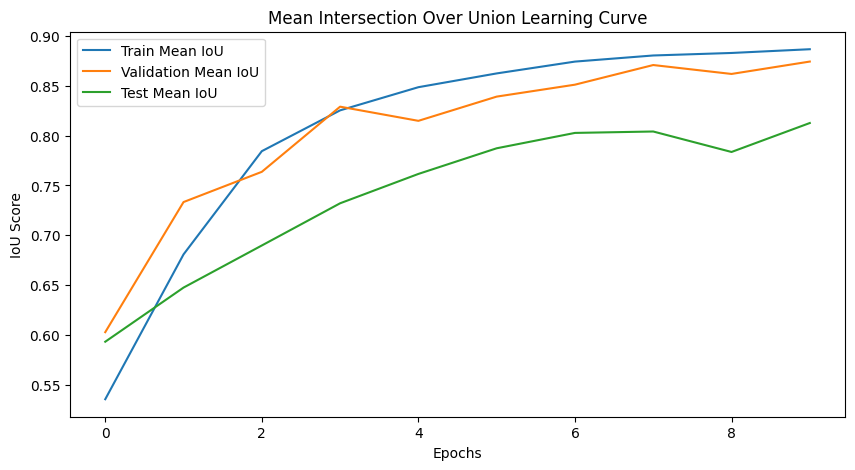

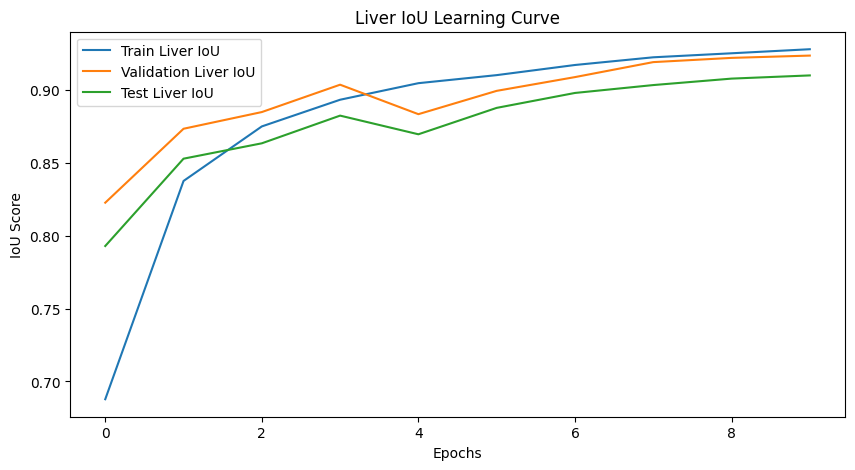

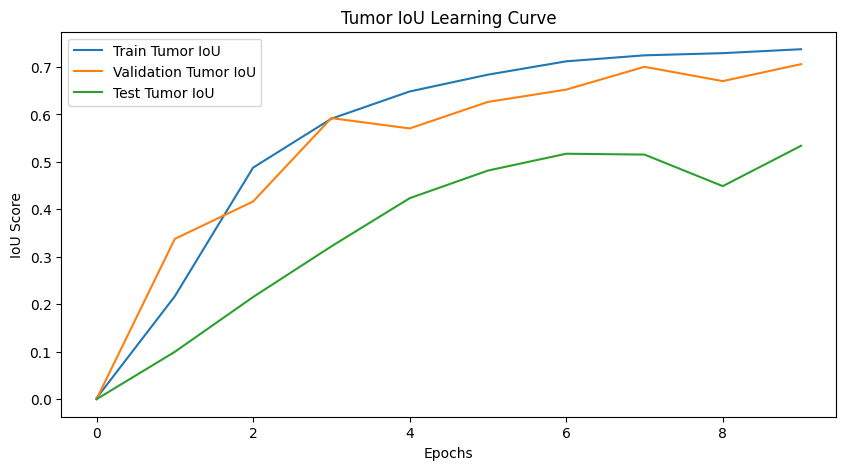

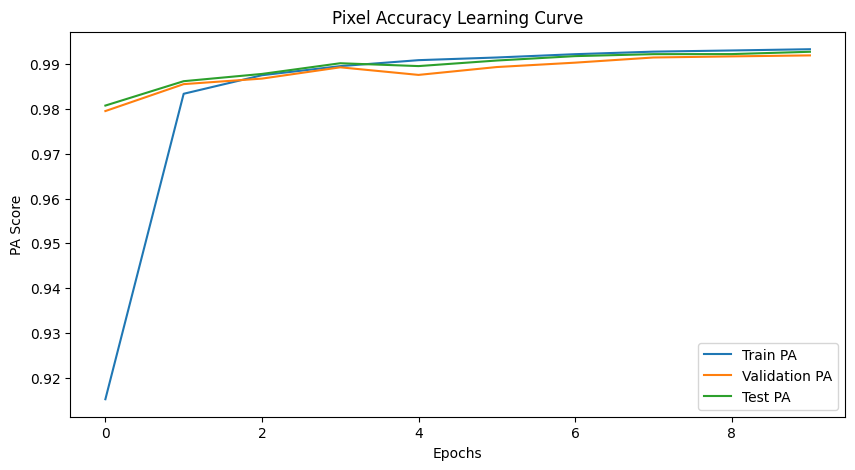

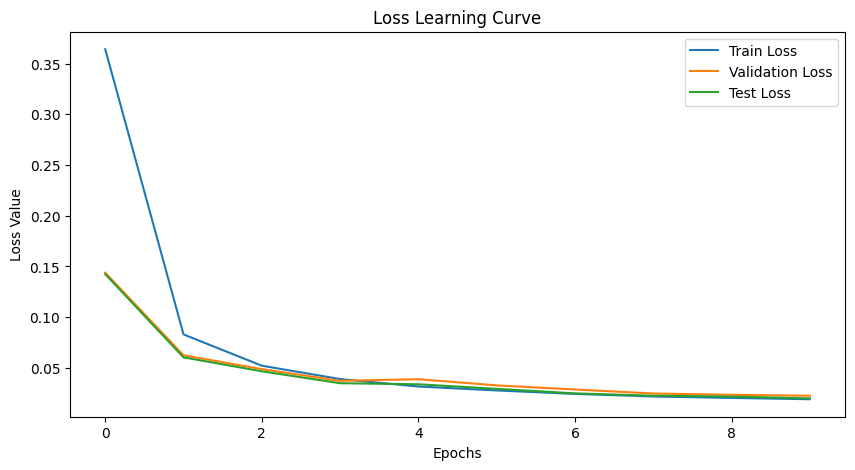

In [6]:
import matplotlib.pyplot as plt

class Plot():
    
    def __init__(self, res):
        
        self.res = res
        
        # Mean IoU Learning Curve
        self.visualize(metric1="tr_miou", metric2="val_miou", test_metric="test_miou",
                       label1="Train Mean IoU", label2="Validation Mean IoU", test_label="Test Mean IoU",
                       title="Mean Intersection Over Union Learning Curve", ylabel="IoU Score")
        
        # Liver IoU Learning Curve
        self.visualize(metric1="tr_liver_iou", metric2="val_liver_iou", test_metric="test_liver_iou",
                       label1="Train Liver IoU", label2="Validation Liver IoU", test_label="Test Liver IoU",
                       title="Liver IoU Learning Curve", ylabel="IoU Score")
        
        # Tumor IoU Learning Curve
        self.visualize(metric1="tr_tumor_iou", metric2="val_tumor_iou", test_metric="test_tumor_iou",
                       label1="Train Tumor IoU", label2="Validation Tumor IoU", test_label="Test Tumor IoU",
                       title="Tumor IoU Learning Curve", ylabel="IoU Score")
        
        # Pixel Accuracy Learning Curve
        self.visualize(metric1="tr_pa", metric2="val_pa", test_metric="test_pa",
                       label1="Train PA", label2="Validation PA", test_label="Test PA",
                       title="Pixel Accuracy Learning Curve", ylabel="PA Score")
        
        # Loss Learning Curve
        self.visualize(metric1="tr_loss", metric2="val_loss", test_metric="test_loss",
                       label1="Train Loss", label2="Validation Loss", test_label="Test Loss",
                       title="Loss Learning Curve", ylabel="Loss Value")
        
    def plot(self, metric, label): 
        plt.plot(self.res[metric], label=label)
    
    def decorate(self, ylabel, title): 
        plt.title(title); plt.xlabel("Epochs"); plt.ylabel(ylabel); plt.legend(); plt.show()
    
    def visualize(self, metric1, metric2, test_metric, label1, label2, test_label, title, ylabel):
        
        plt.figure(figsize=(10, 5))
        self.plot(metric1, label1)
        self.plot(metric2, label2)
        self.plot(test_metric, test_label)  # Plotting test metric
        self.decorate(ylabel, title)                

# Assuming `history` contains the metrics dictionary returned by the `train` function
Plot(history)


# Results

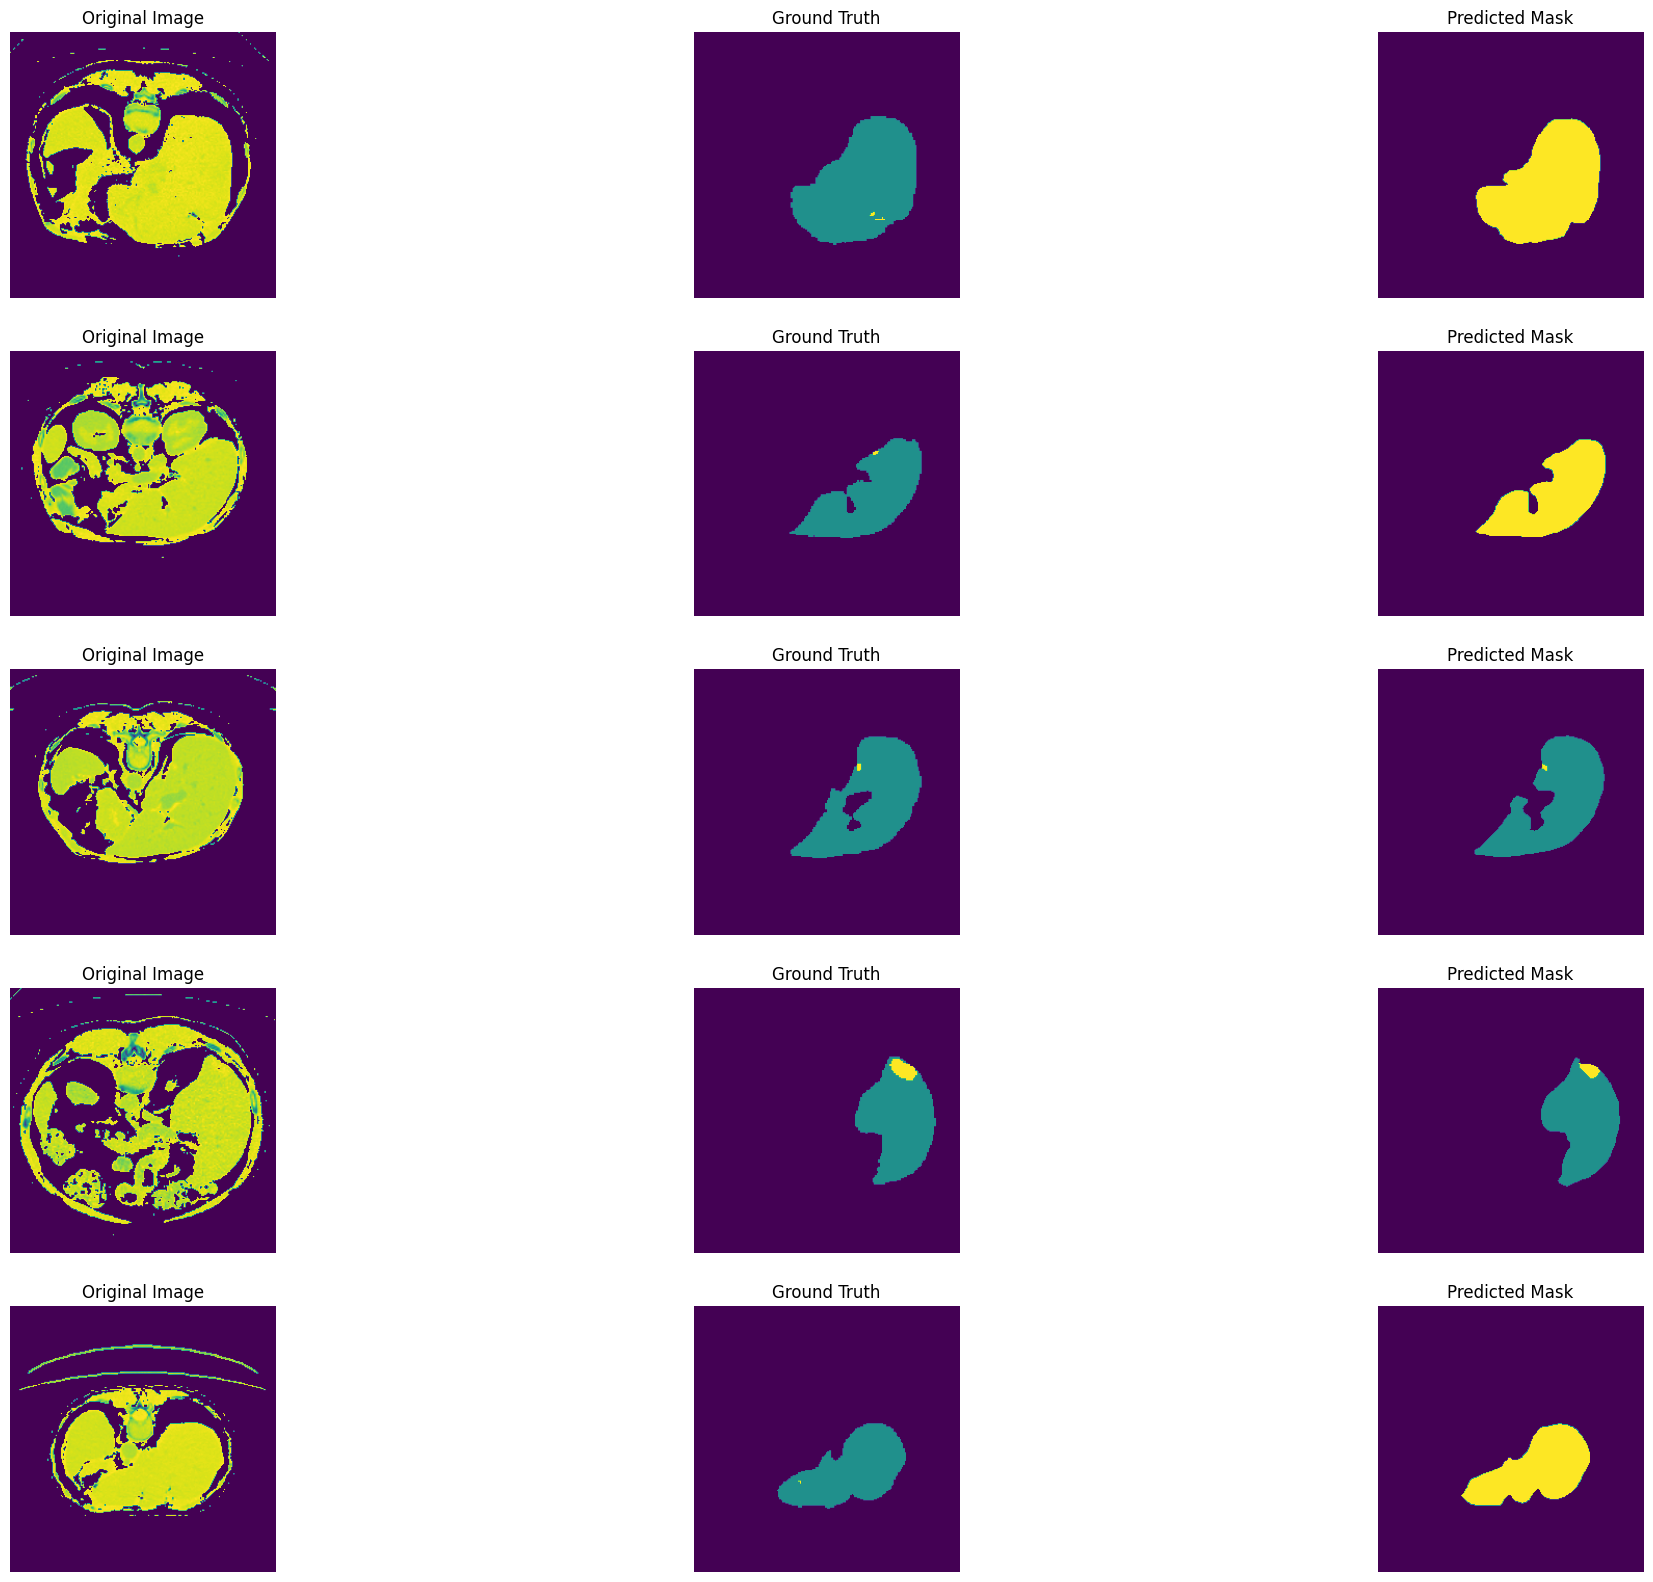

In [7]:
def inference(dl, model, device, n_ims = 15):
    
    cols = n_ims // 3; rows = n_ims // cols
    
    count = 1
    ims, gts, preds = [], [], []
    for idx, data in enumerate(dl):
        im, gt = data

        # Get predicted mask
        with torch.no_grad(): pred = torch.argmax(model(im.to(device)), dim = 1)
        ims.append(im); gts.append(gt); preds.append(pred)
        
    plt.figure(figsize = (25, 20))
    for idx, (im, gt, pred) in enumerate(zip(ims, gts, preds)):
        if idx == cols: break
        # First plot
        count = plot(cols, rows, count, im.squeeze(0))

        # Second plot
        count = plot(cols, rows, count, im = gt.squeeze(0), gt = True, title = "Ground Truth")

        # Third plot
        count = plot(cols, rows, count, im = pred, title = "Predicted Mask")
        
model = torch.load("saved_models/liver_best_model.pt")
inference(test_dl, model = model, device = device)

## Feature Maps

In [8]:
# Define a hook function to extract feature maps
def hook_fn(module, input, output):
    global feature_maps, layer_names
    feature_maps = output.cpu().detach().numpy()
    layer_names = module.__class__.__name__

# Define a function to register hooks for feature map extraction
def register_hooks(model):
    for name, layer in model.named_modules():
        if isinstance(layer, torch.nn.Conv2d):
            layer.register_forward_hook(hook_fn)

# Register hooks for feature map extraction
register_hooks(model)

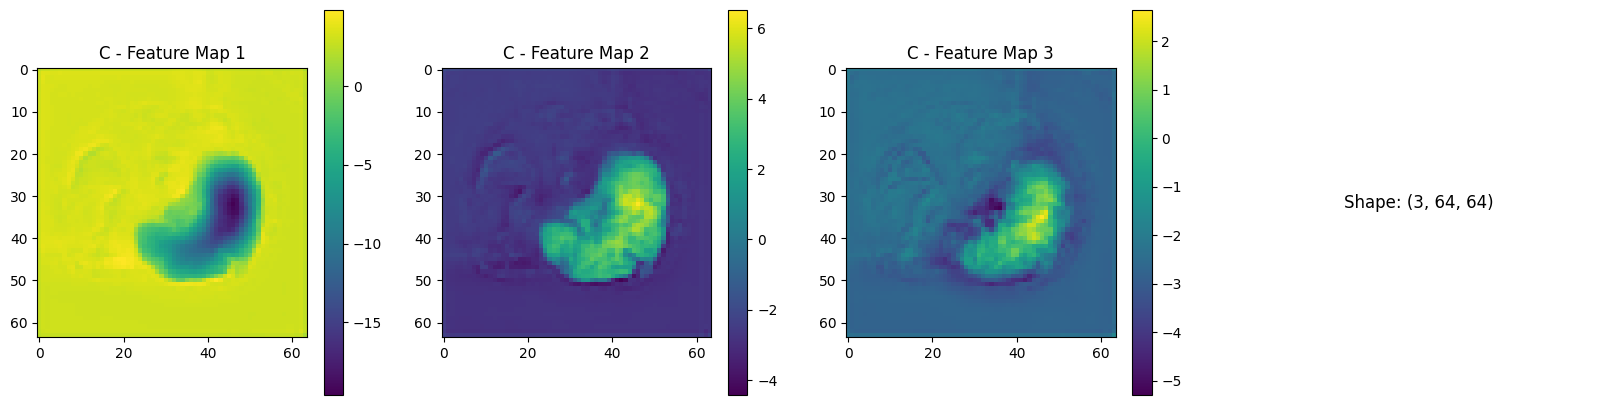

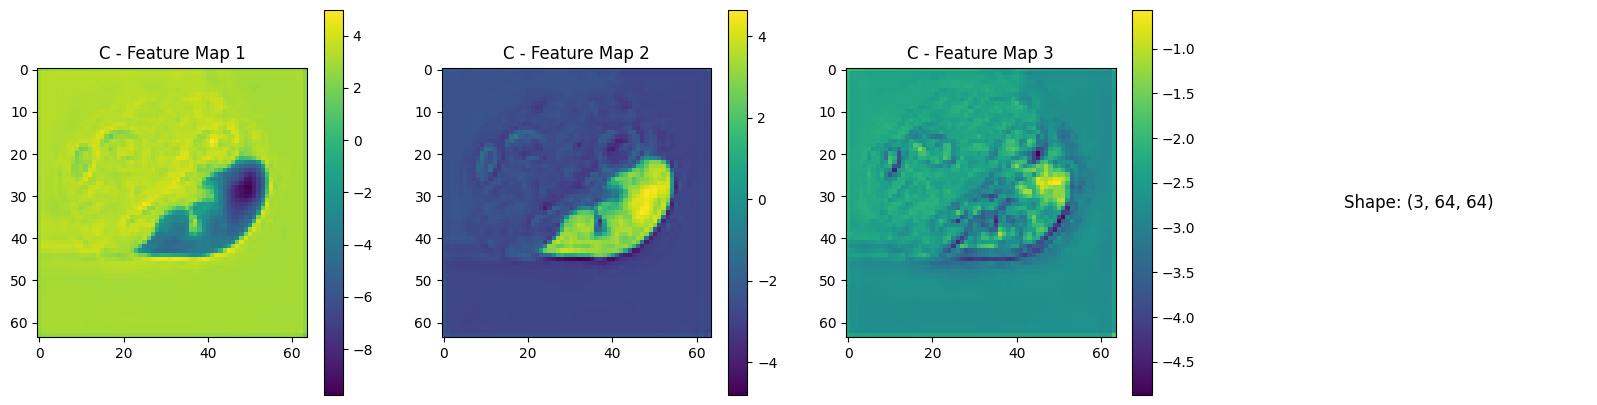

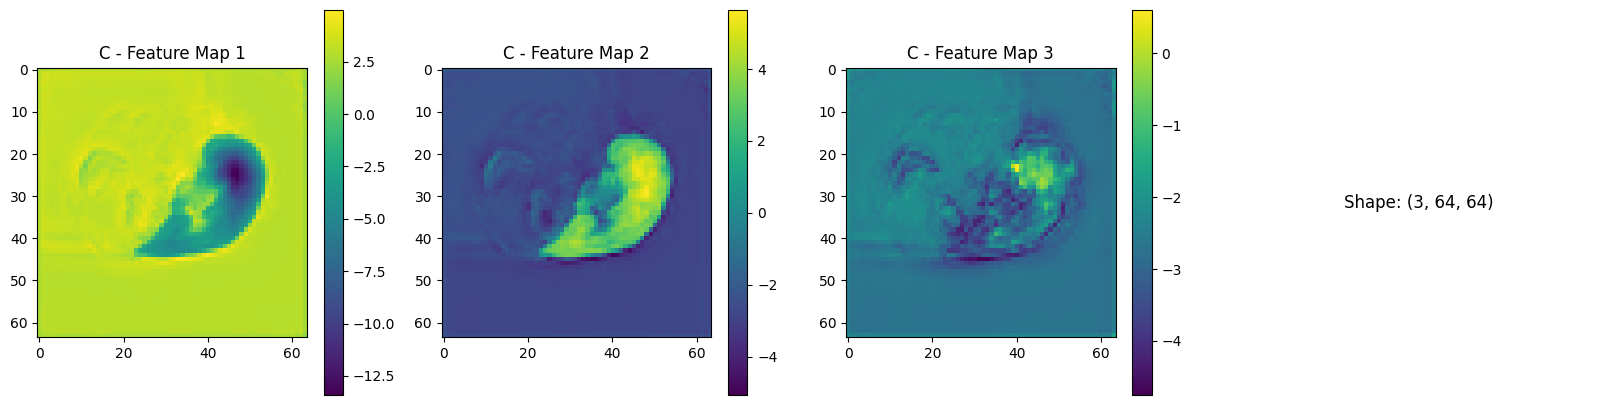

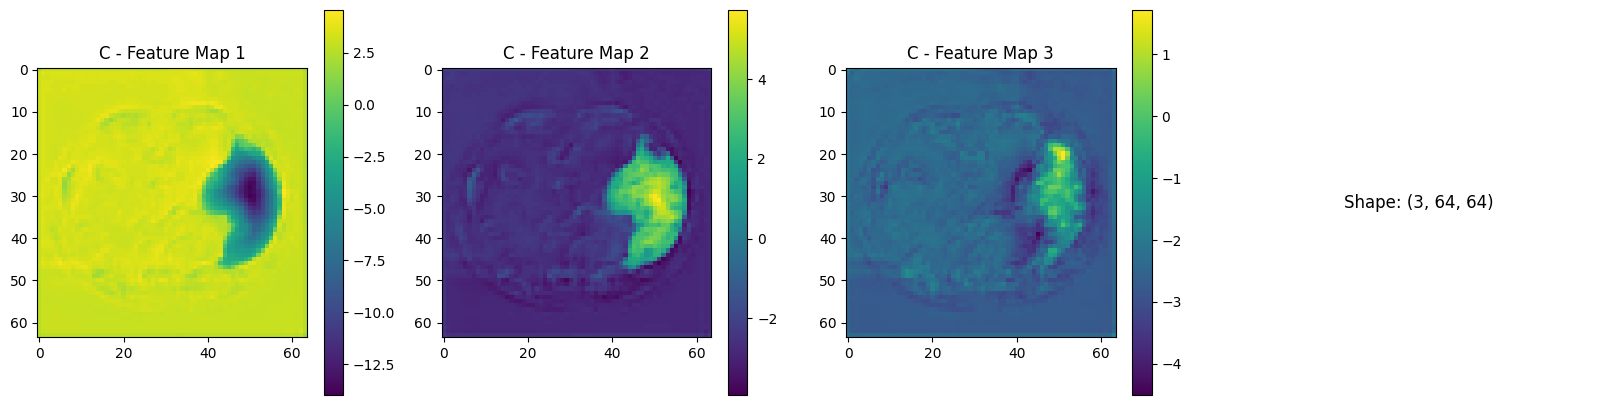

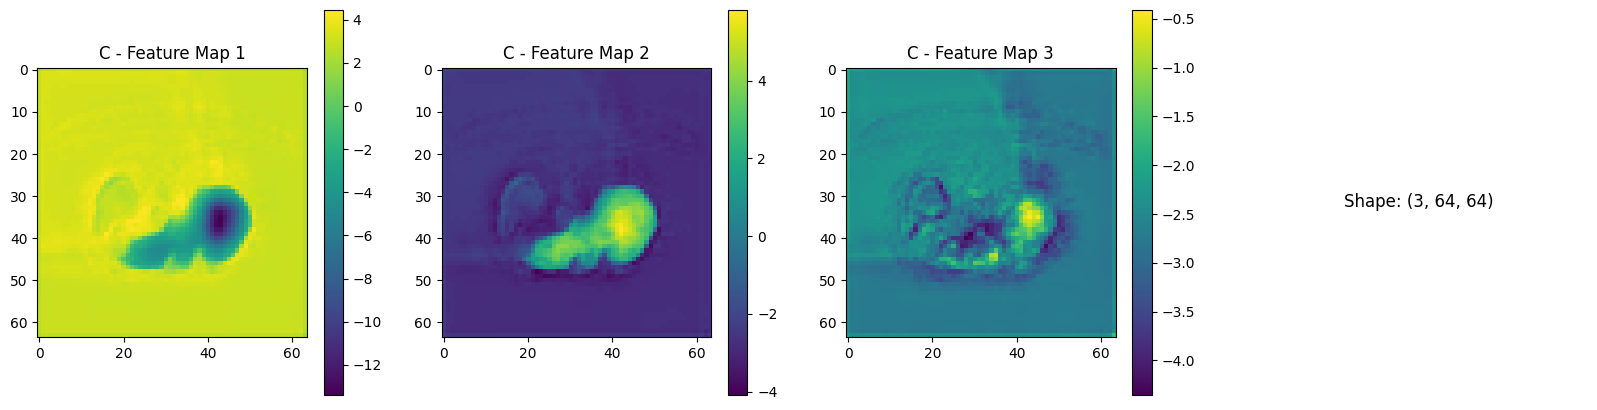

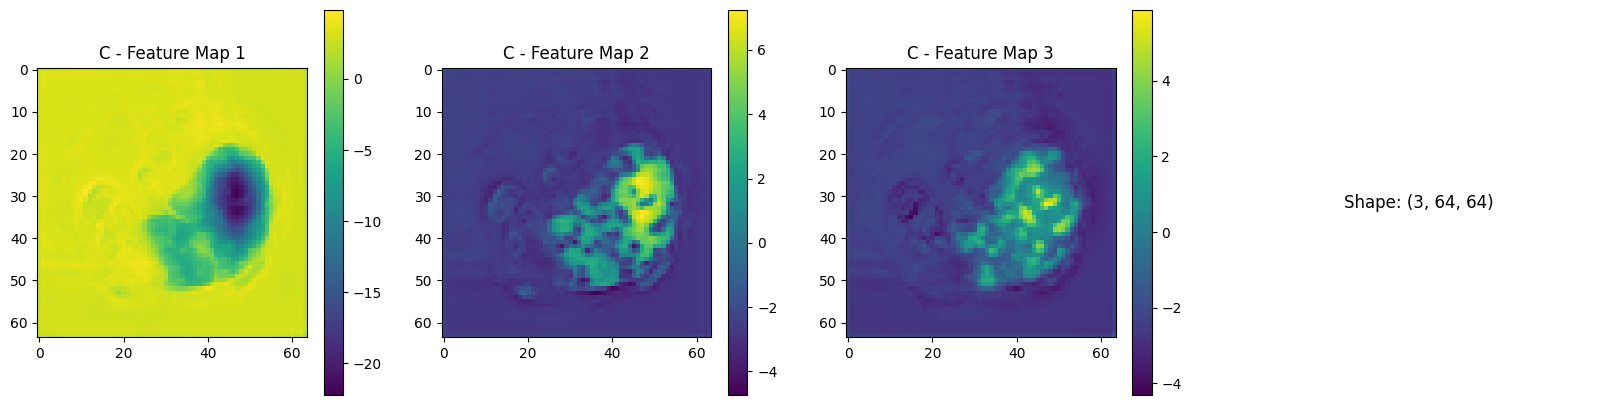

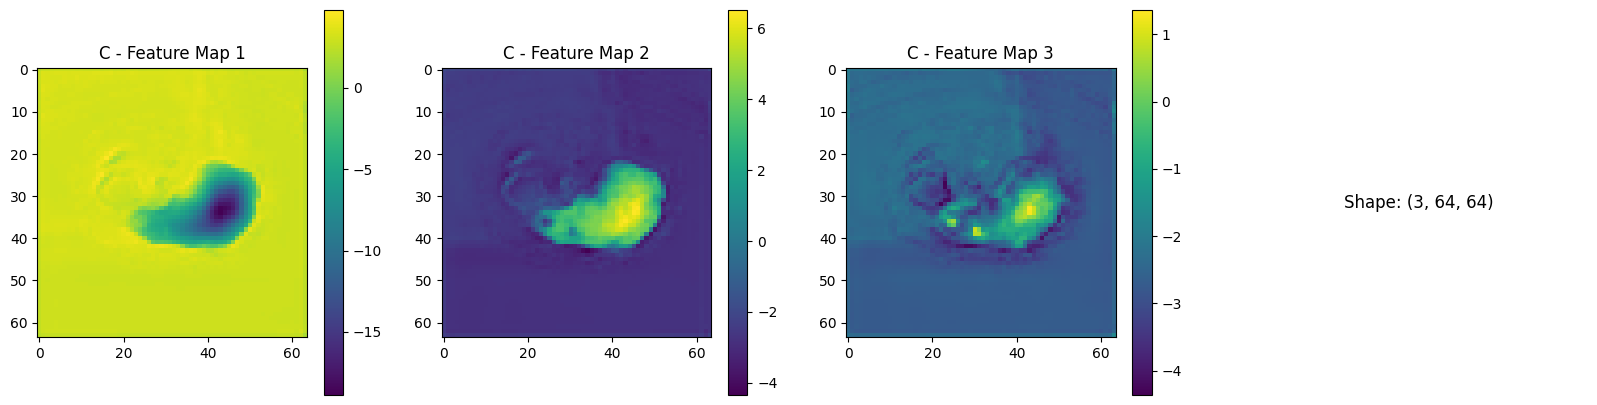

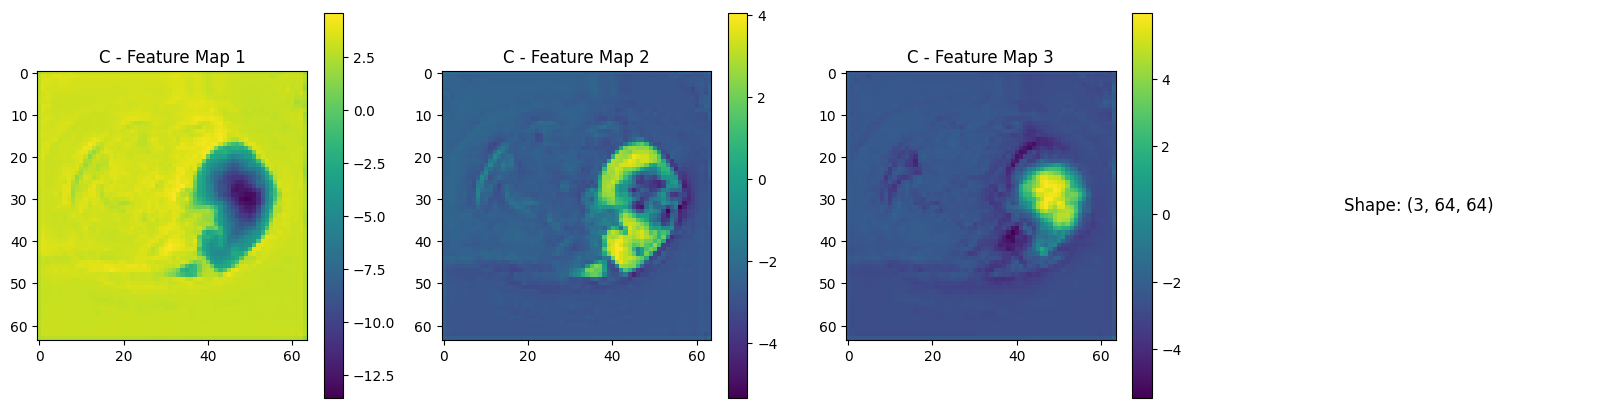

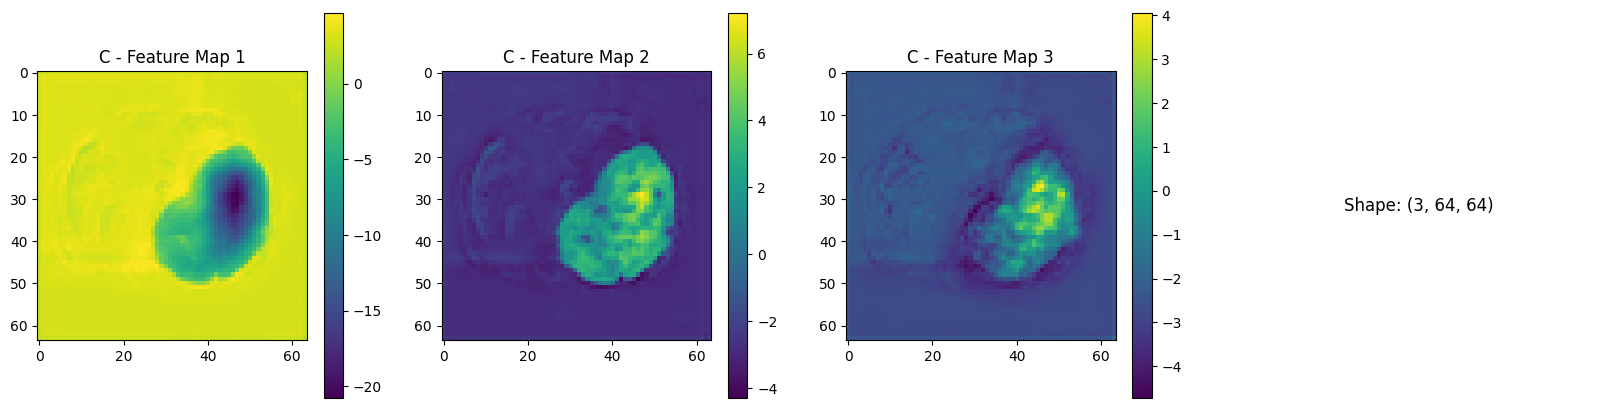

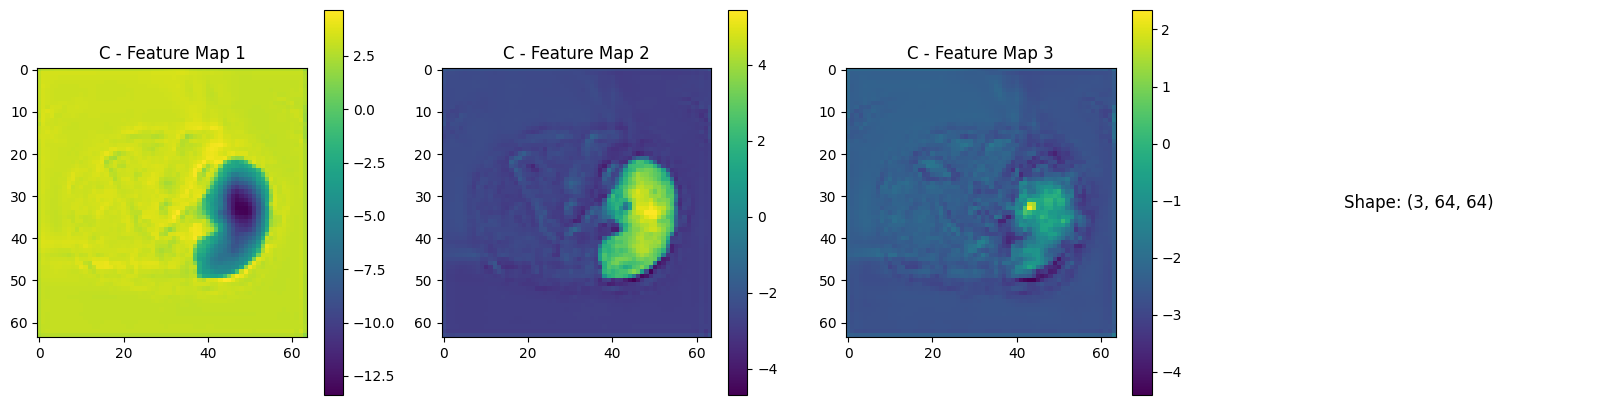

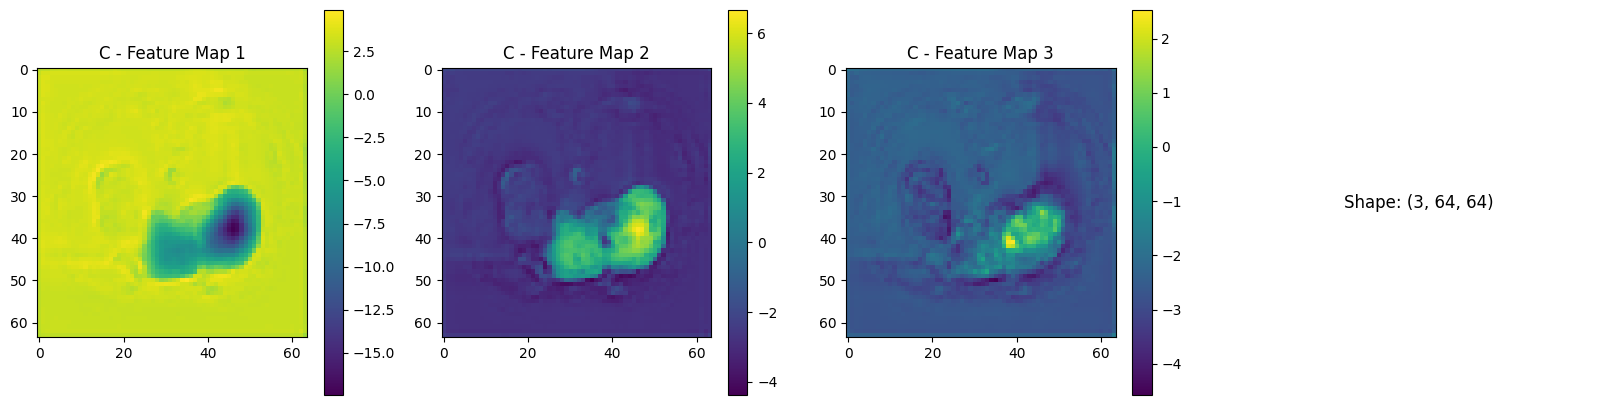

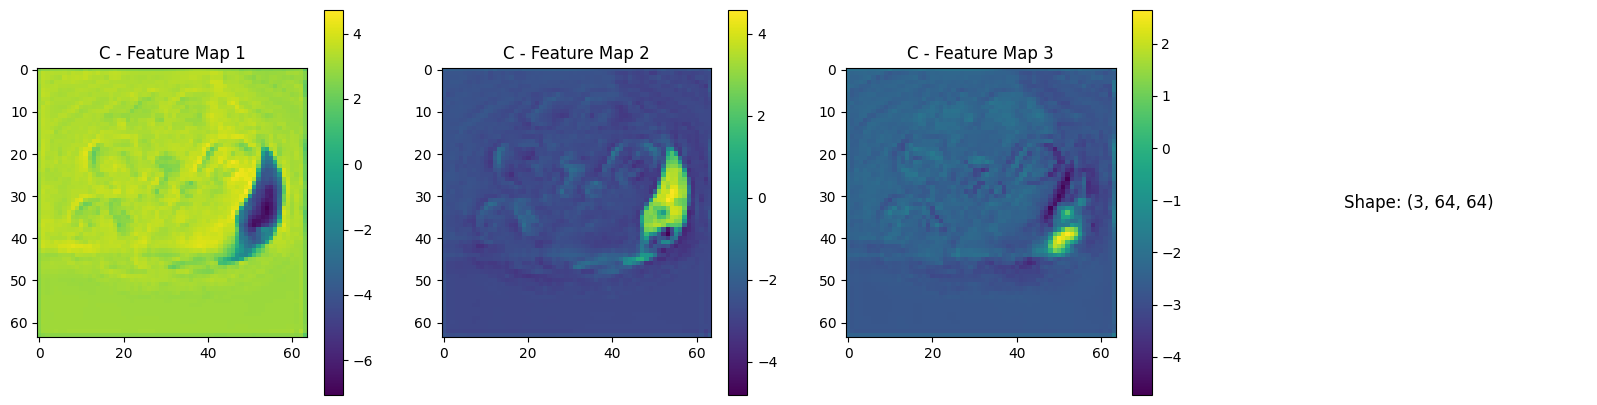

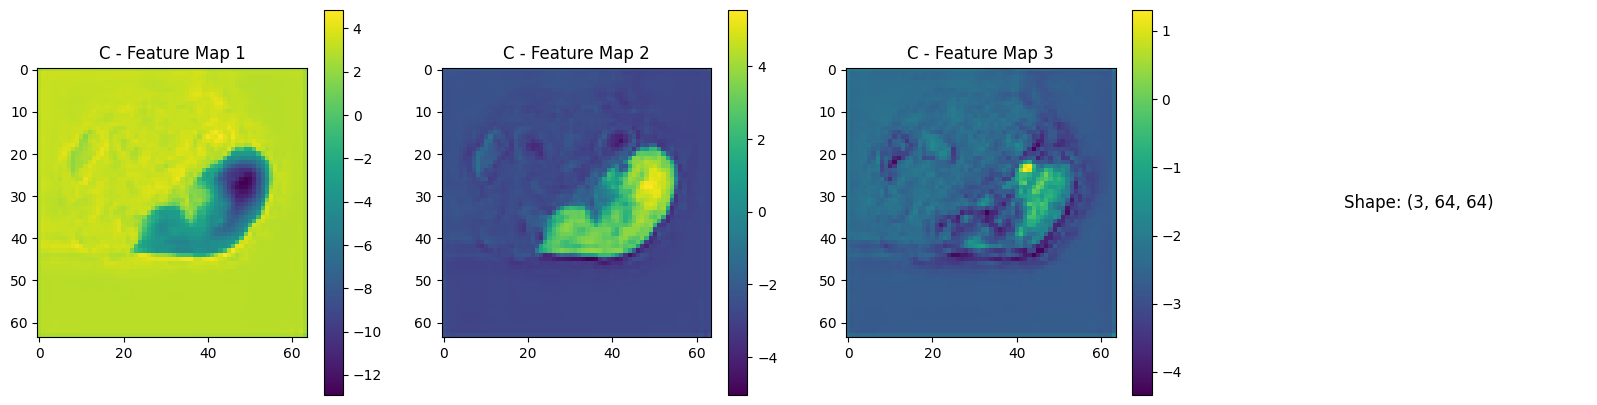

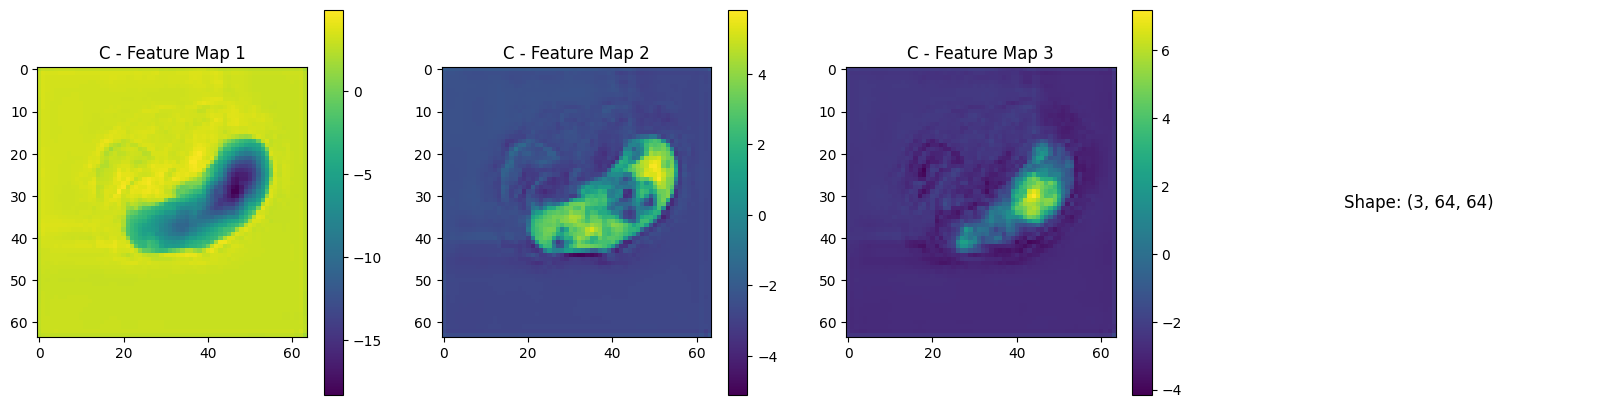

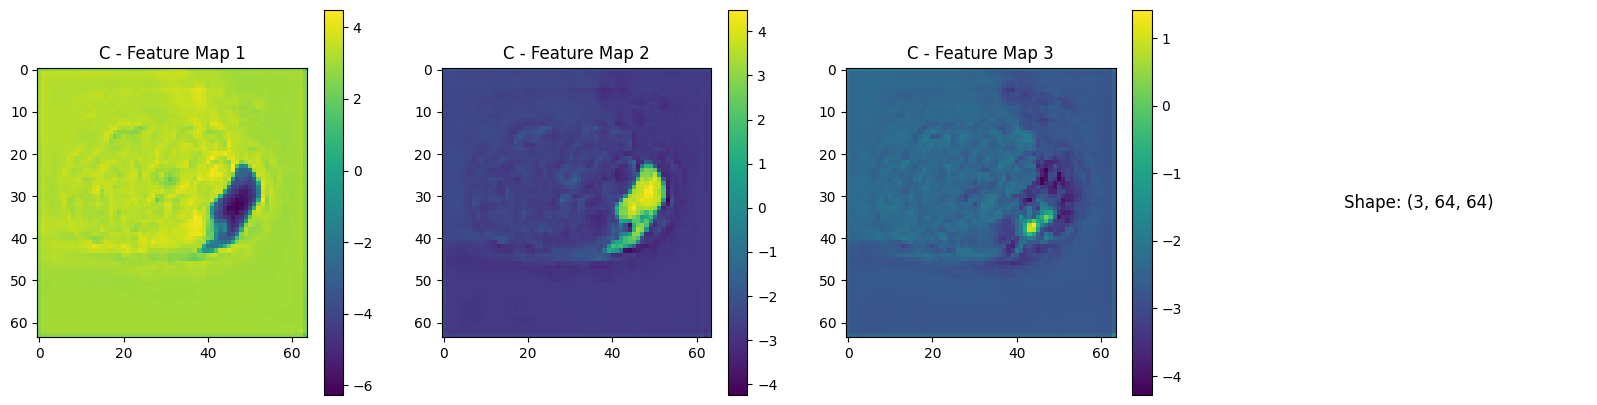

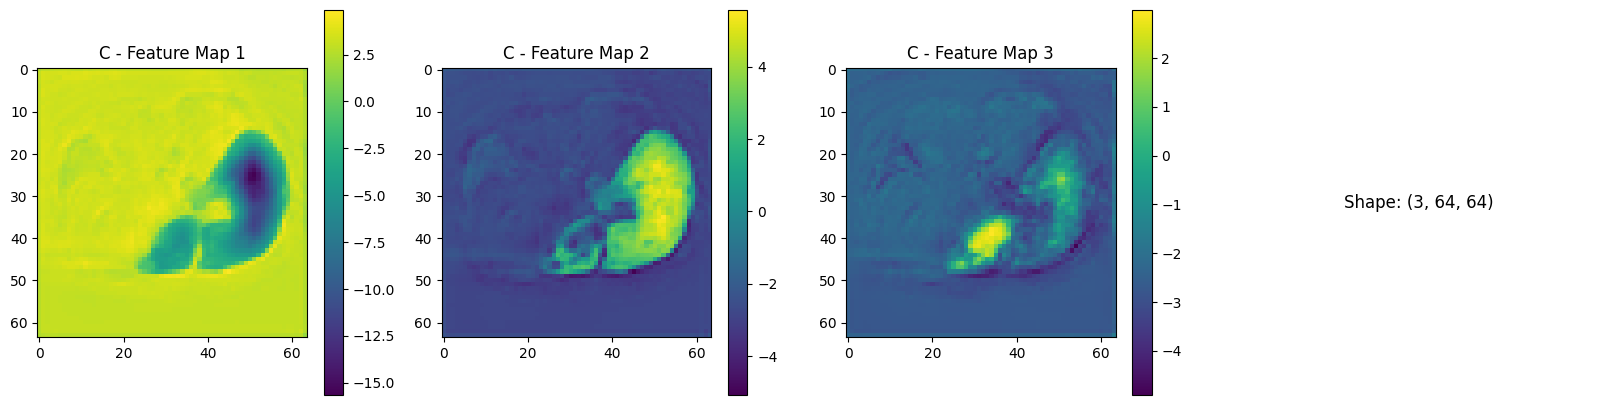

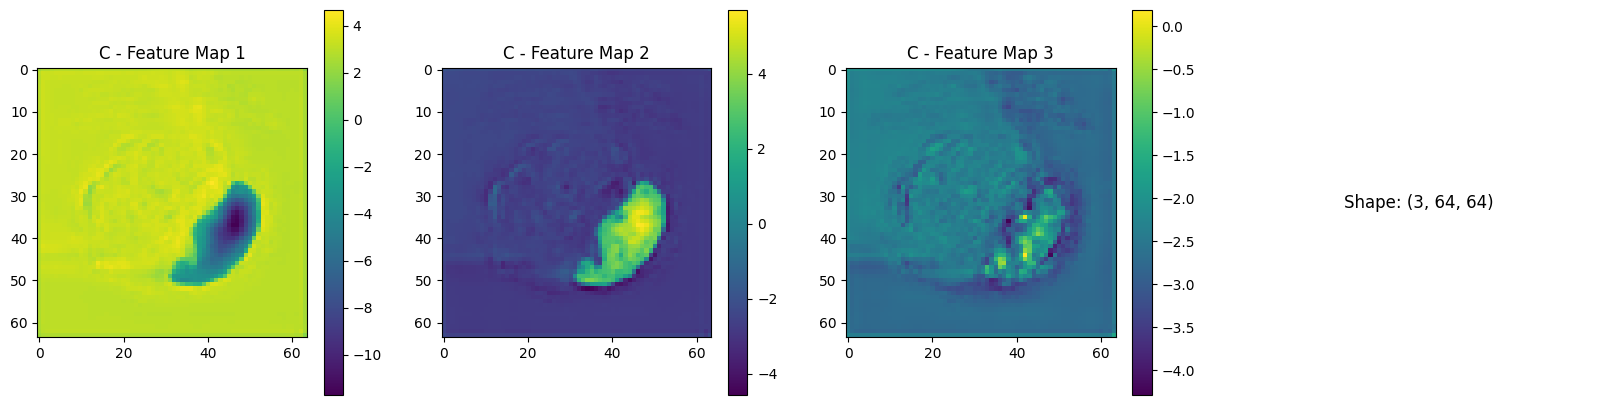

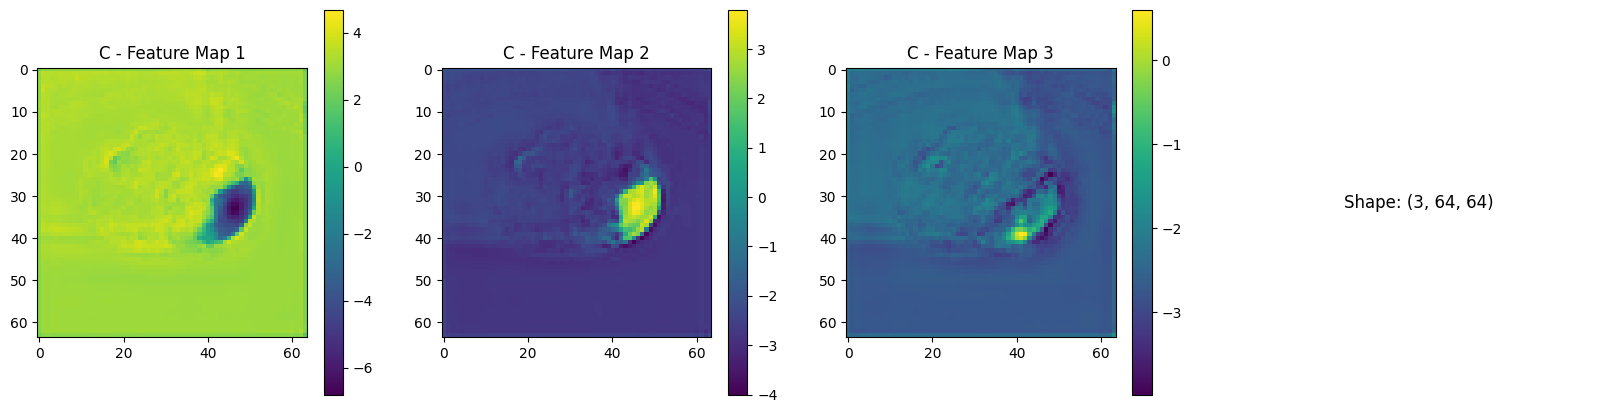

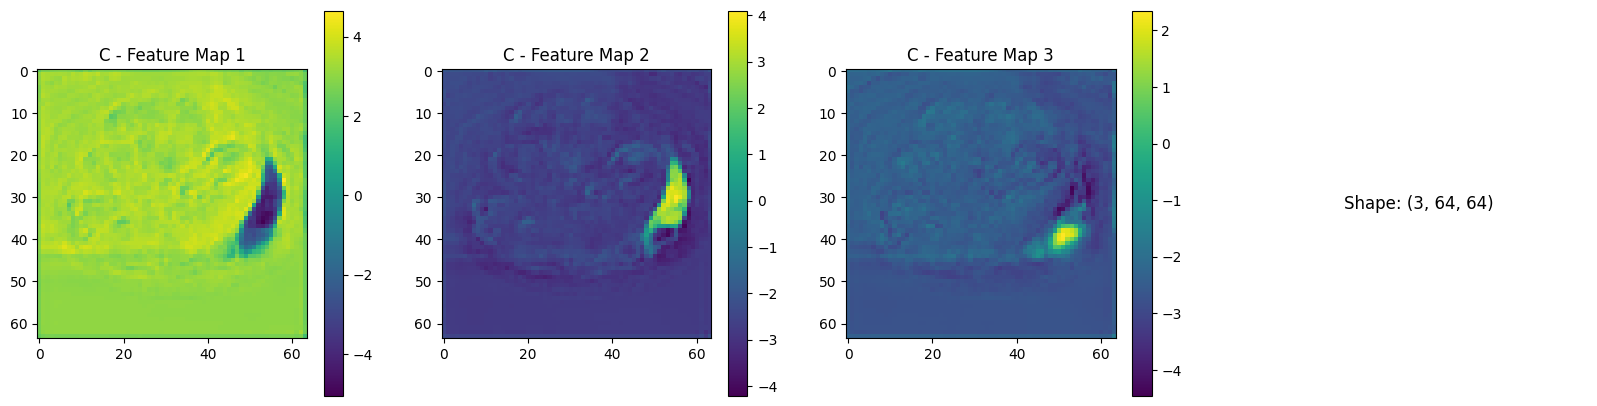

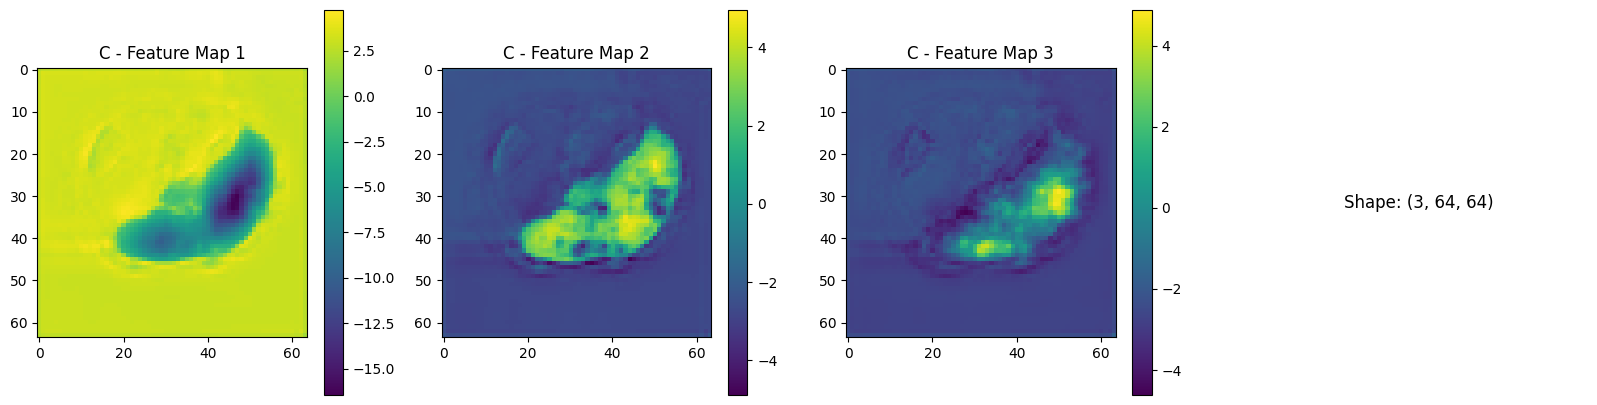

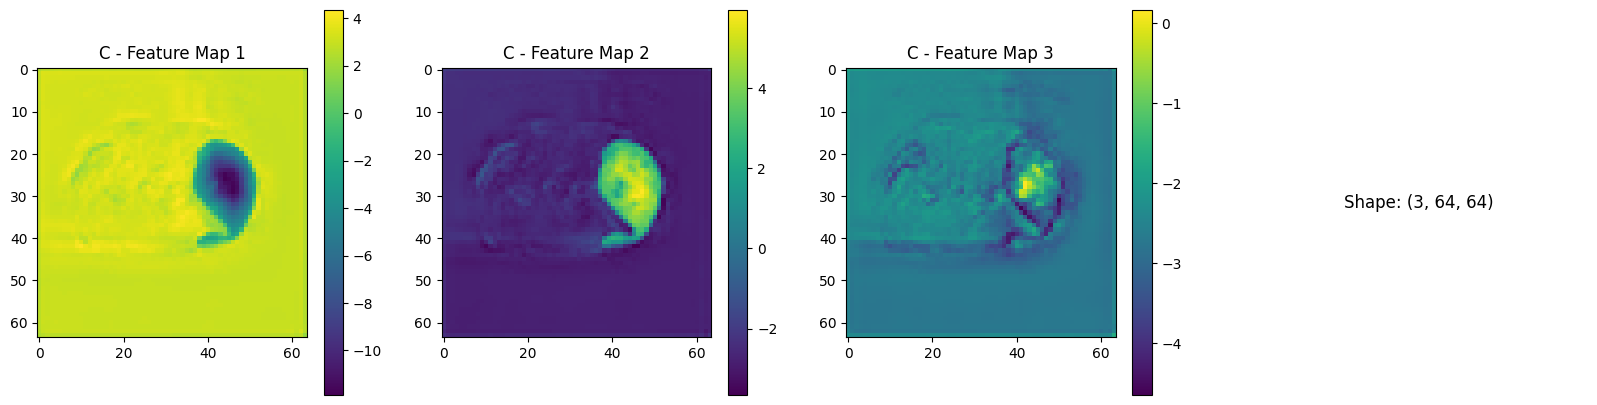

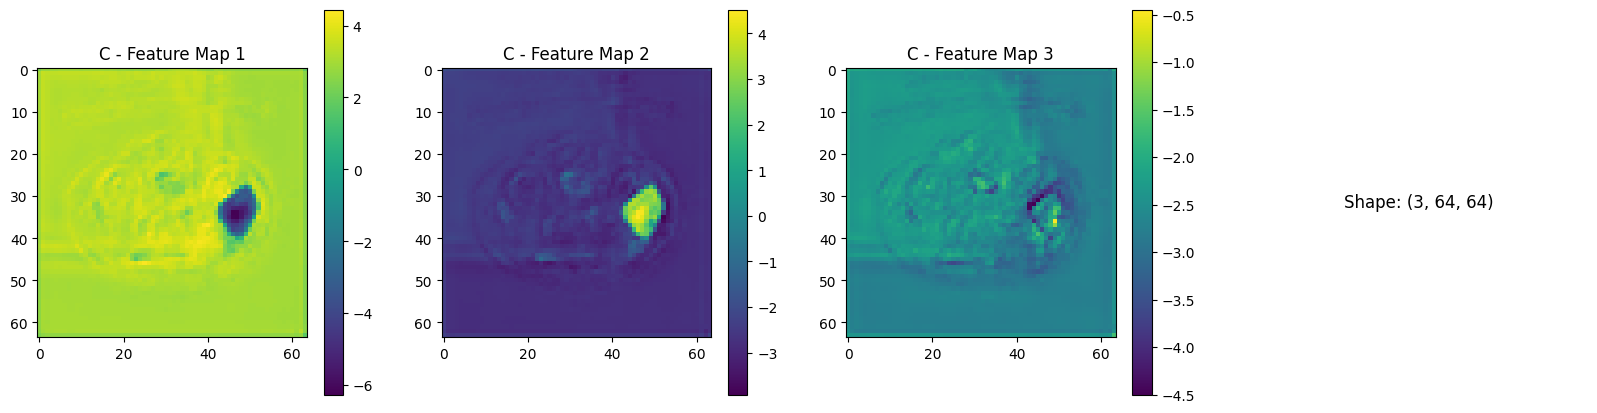

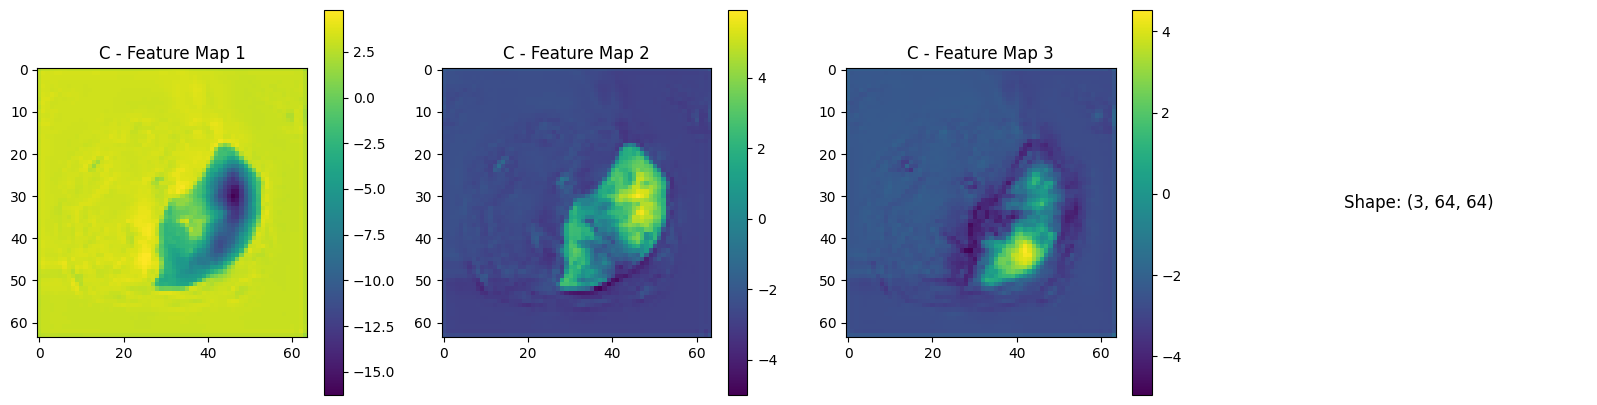

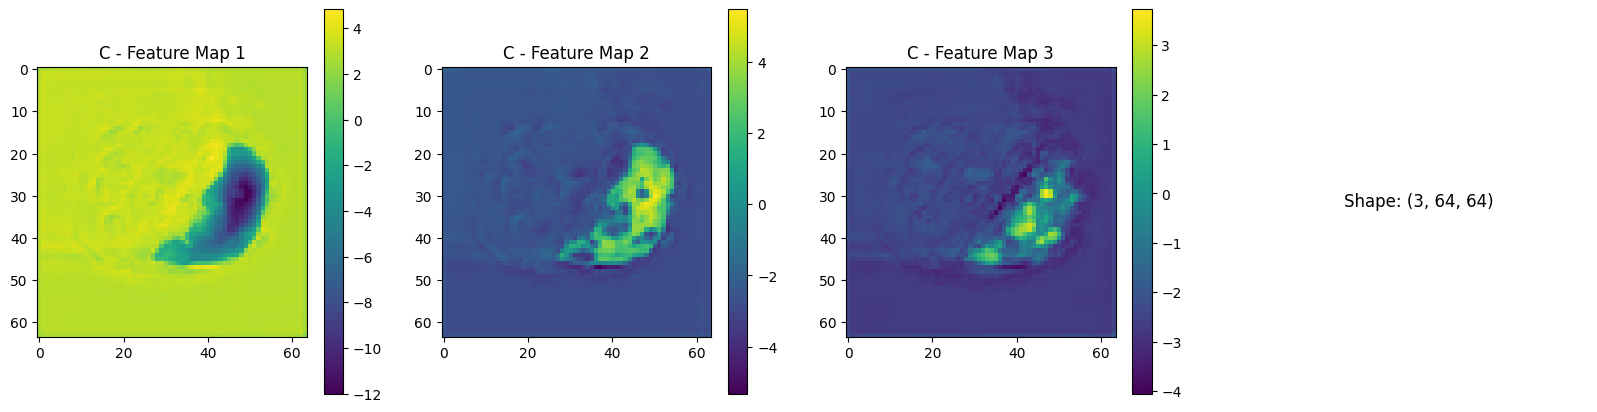

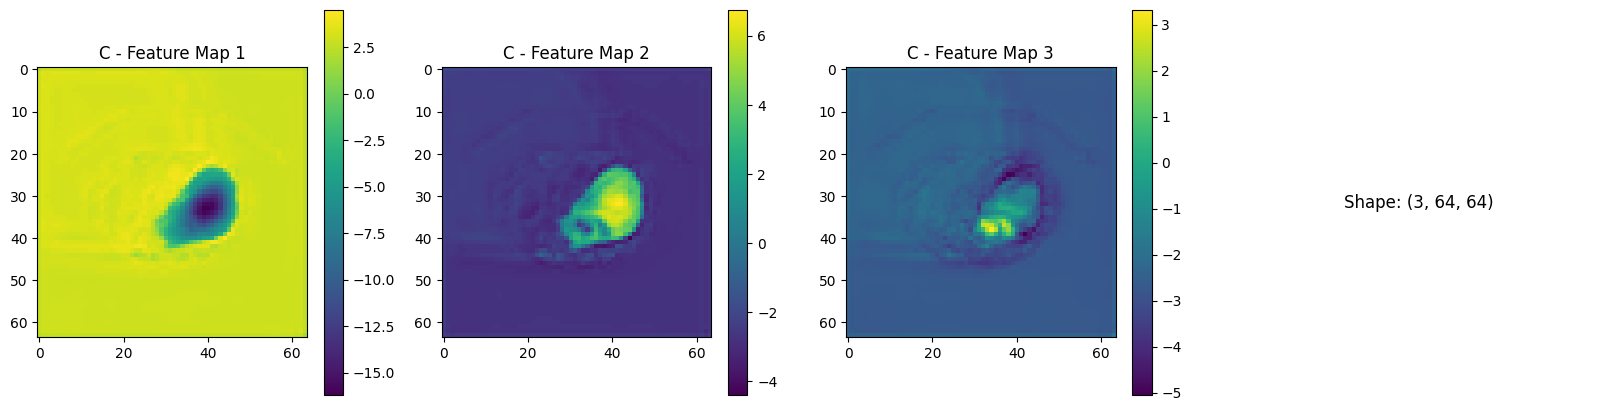

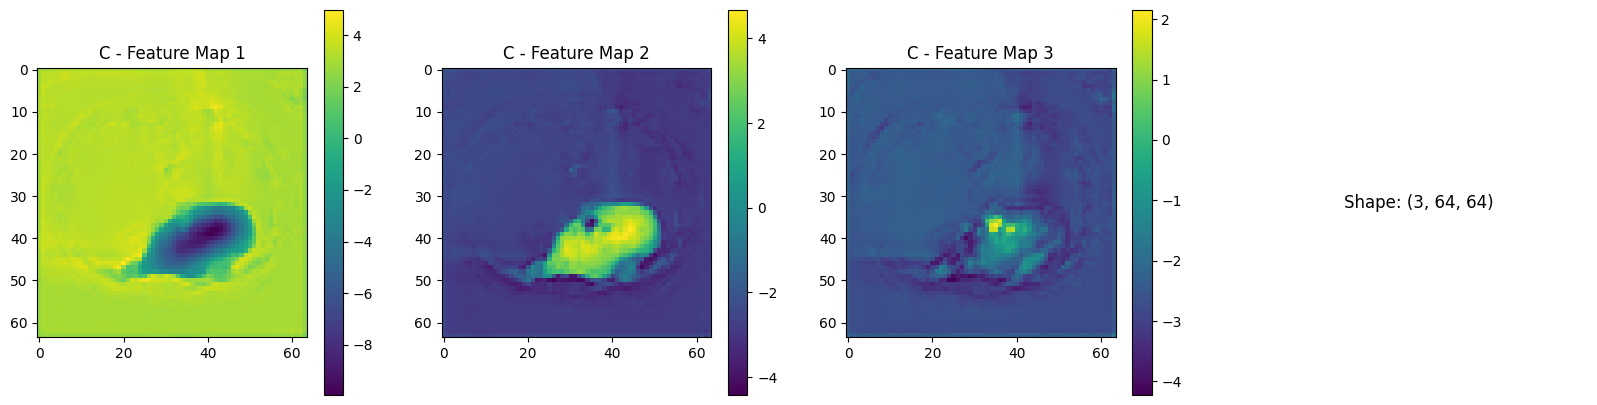

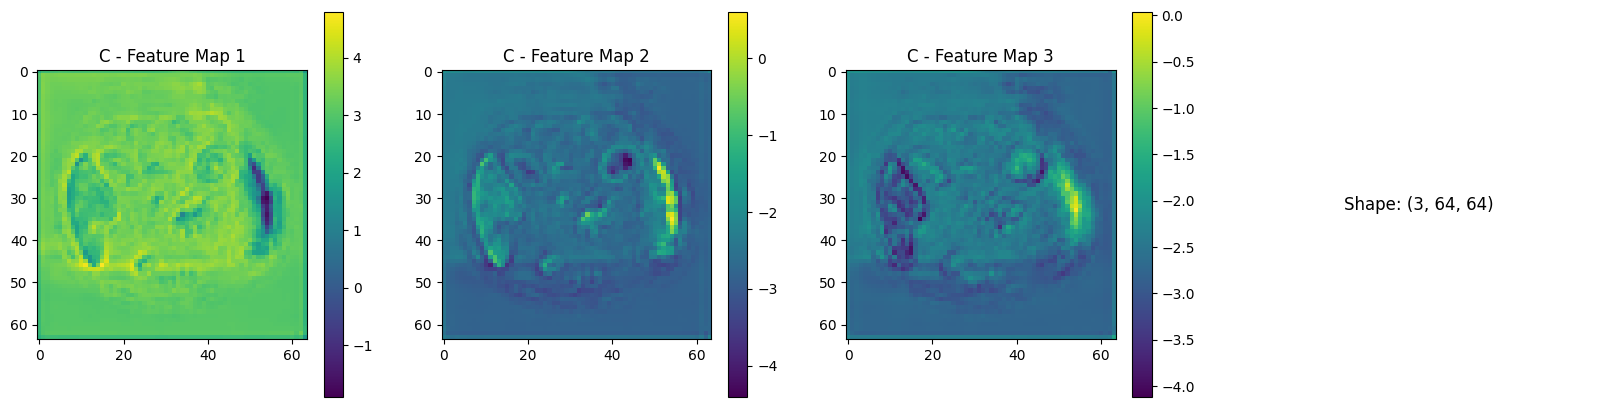

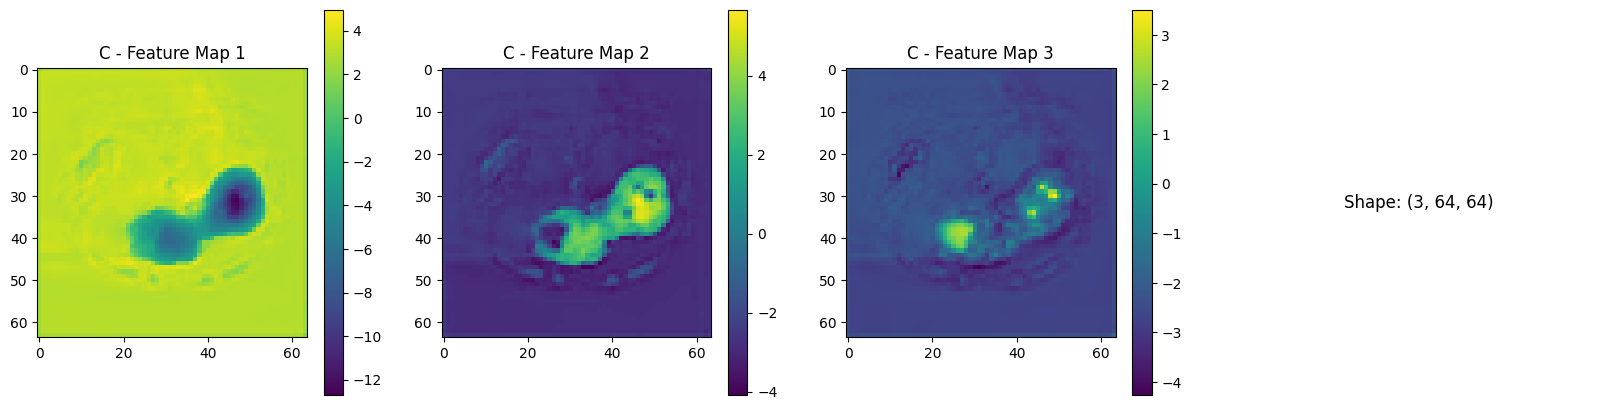

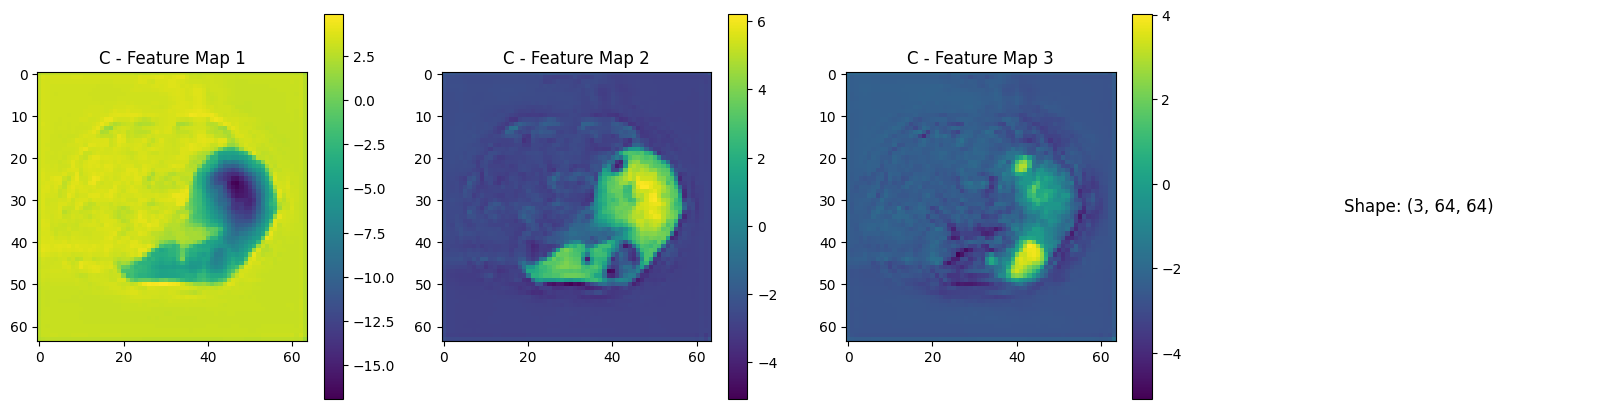

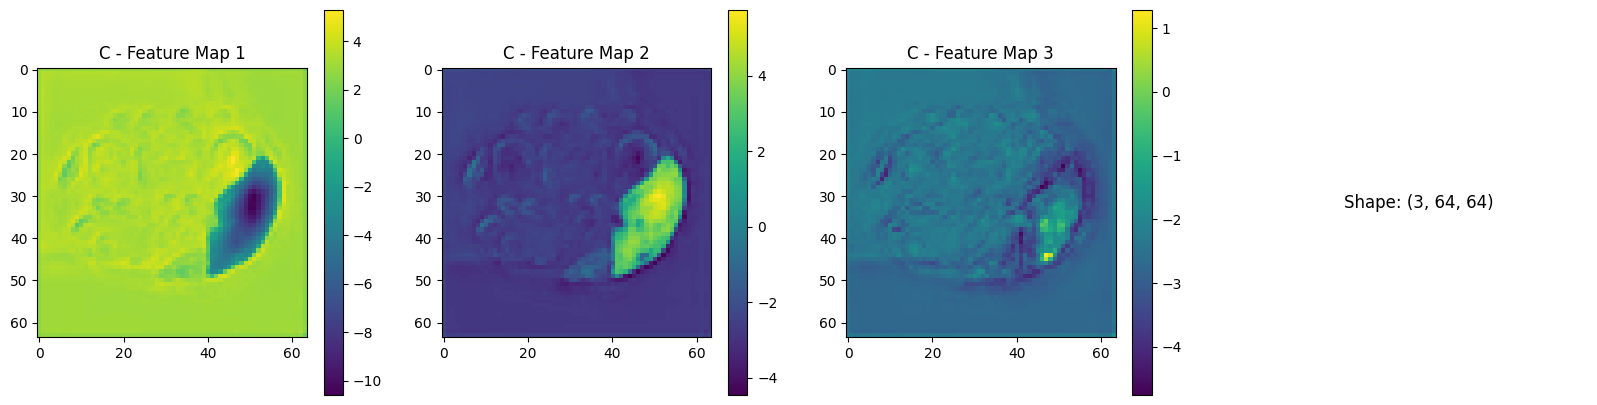

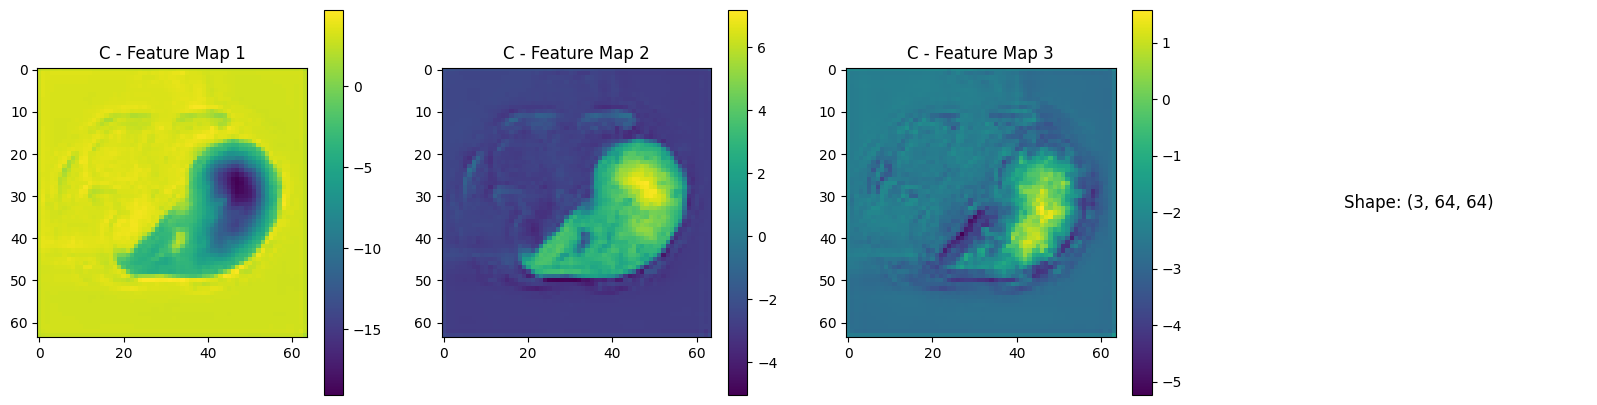

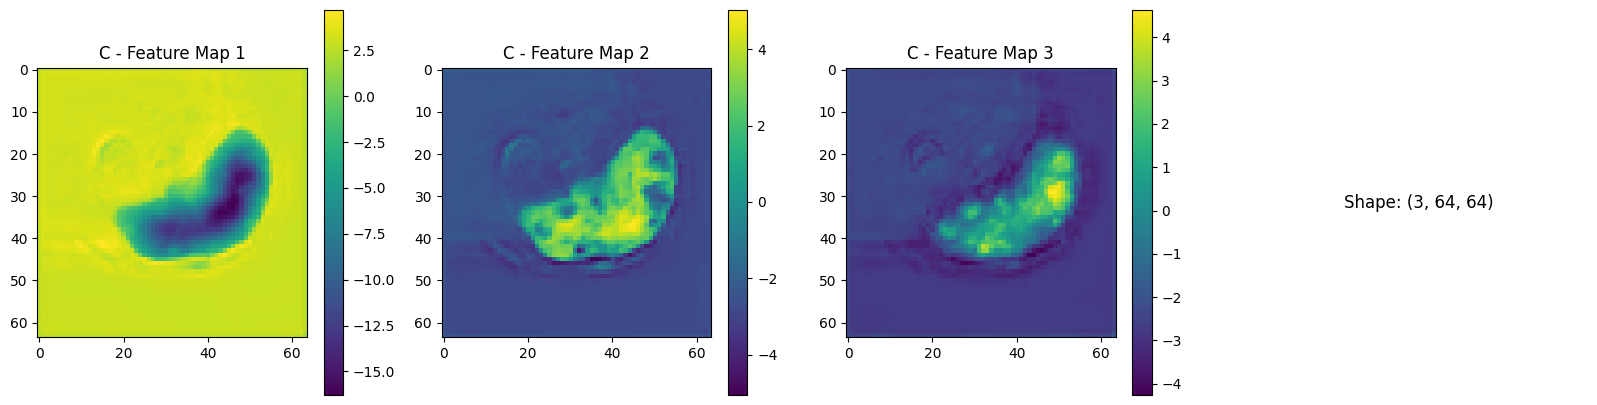

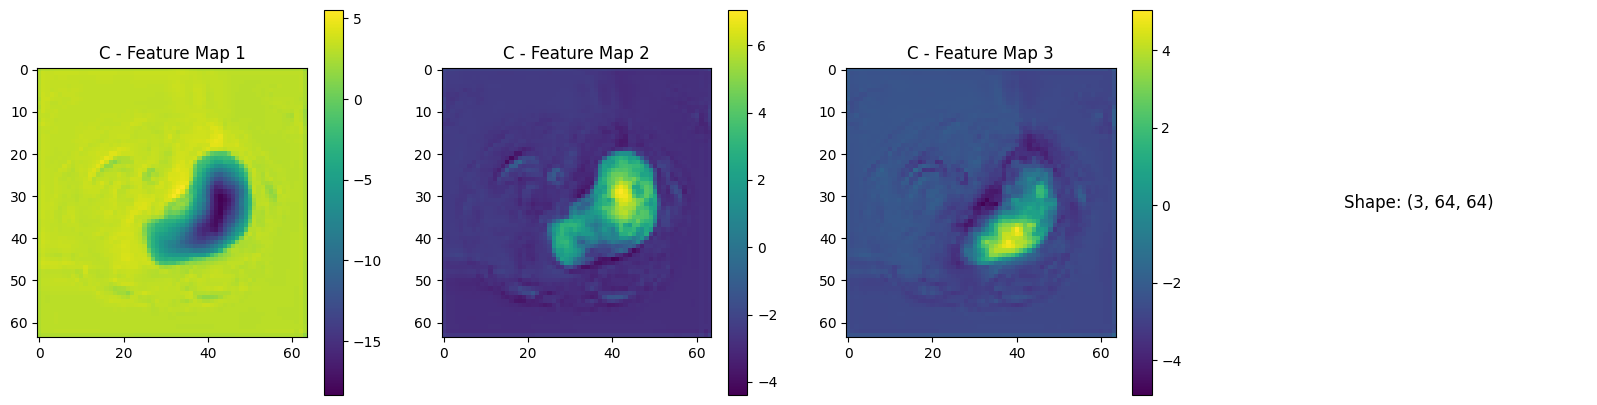

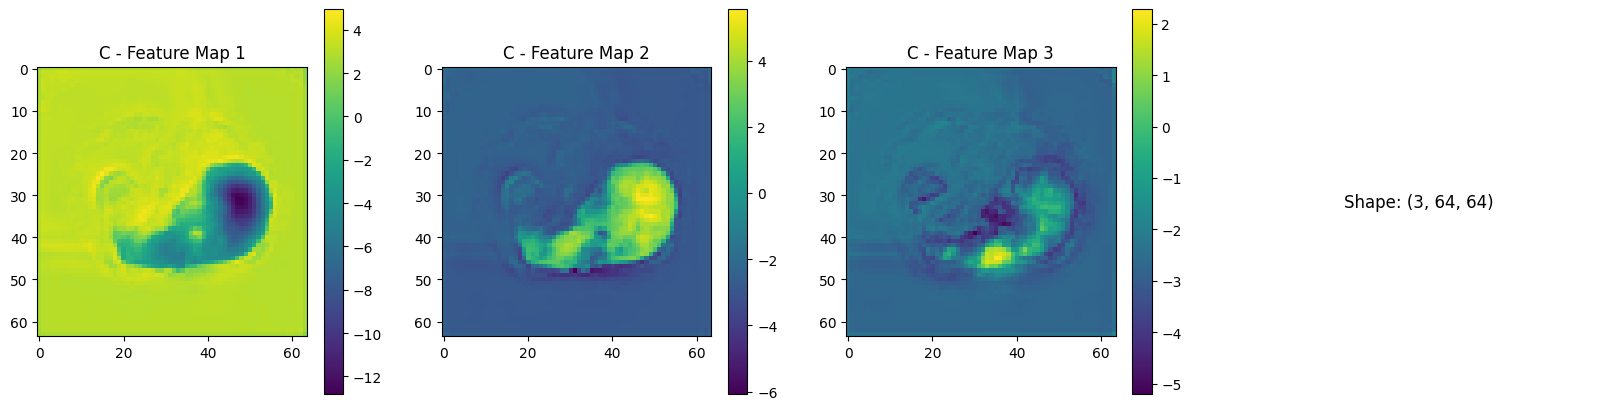

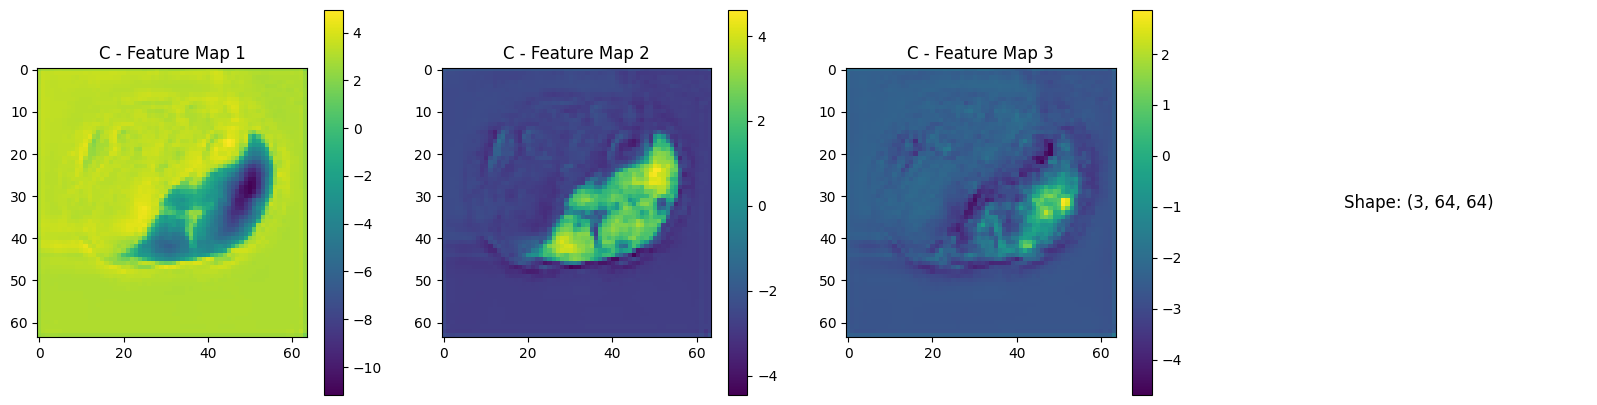

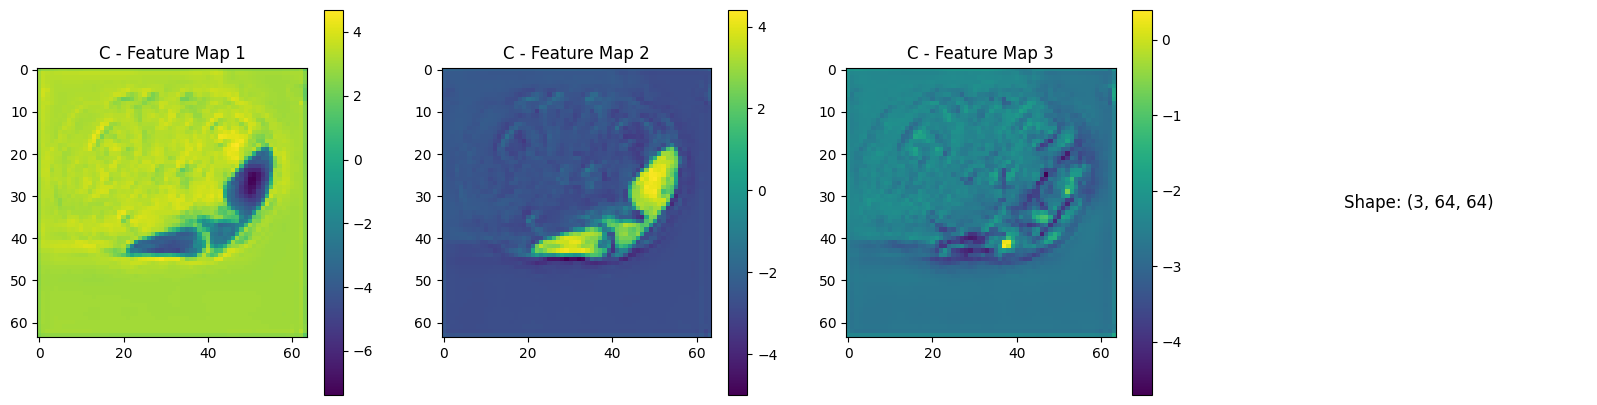

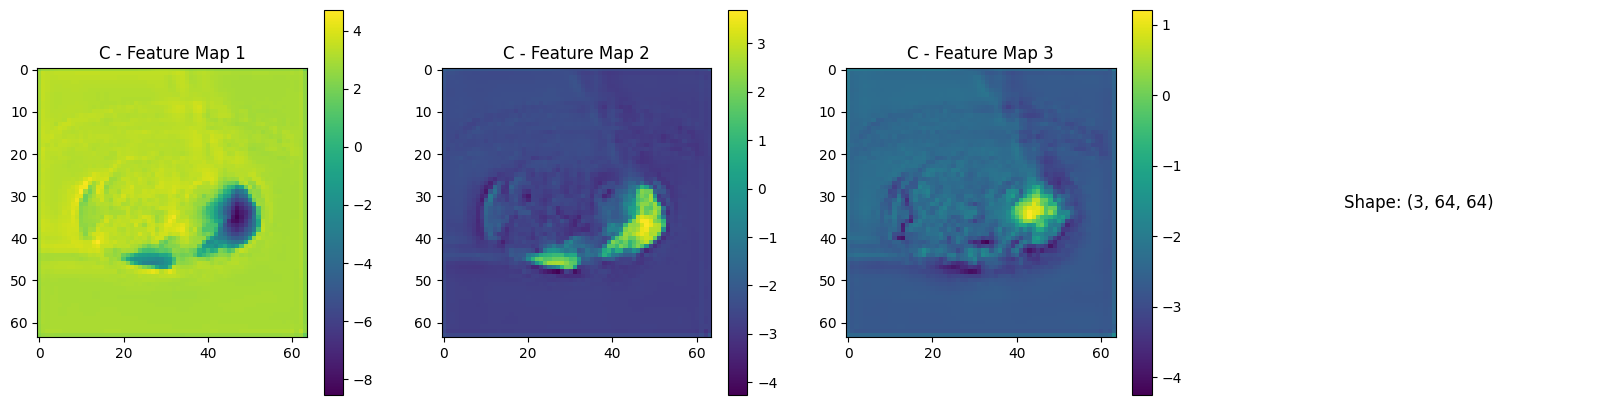

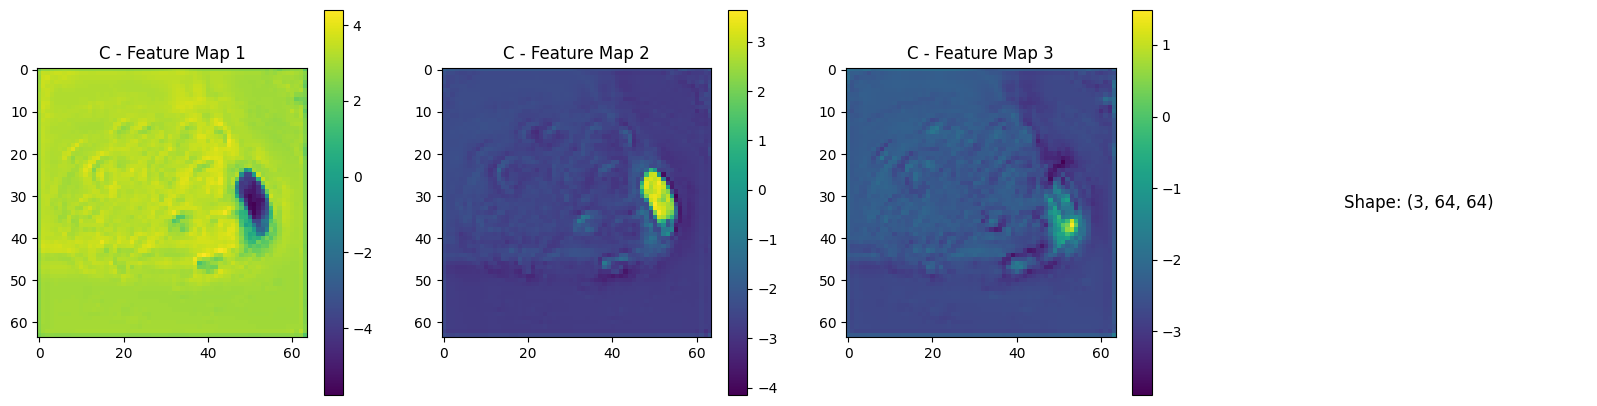

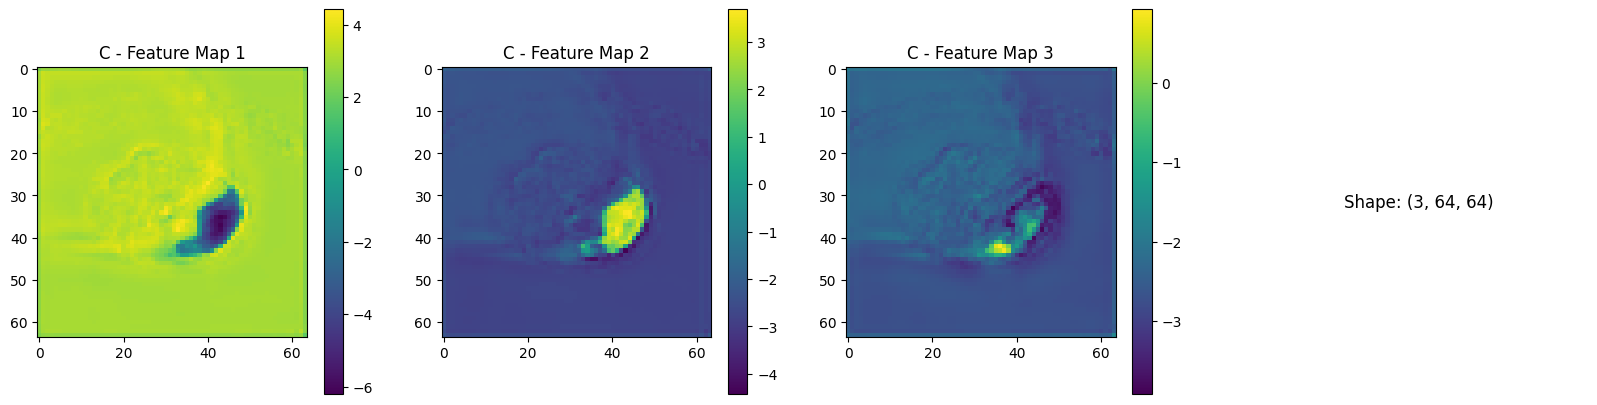

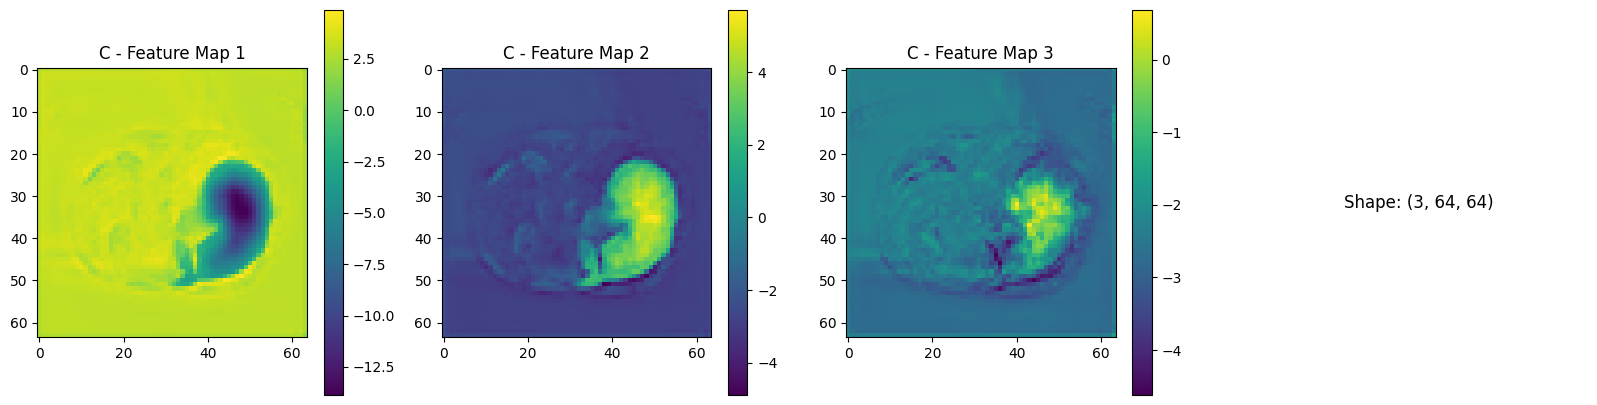

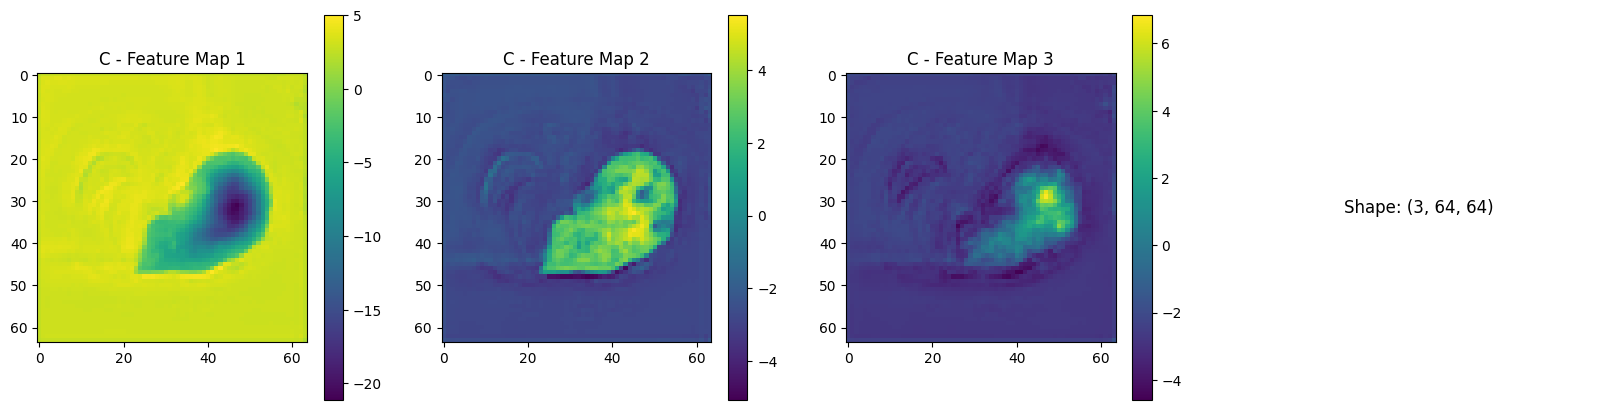

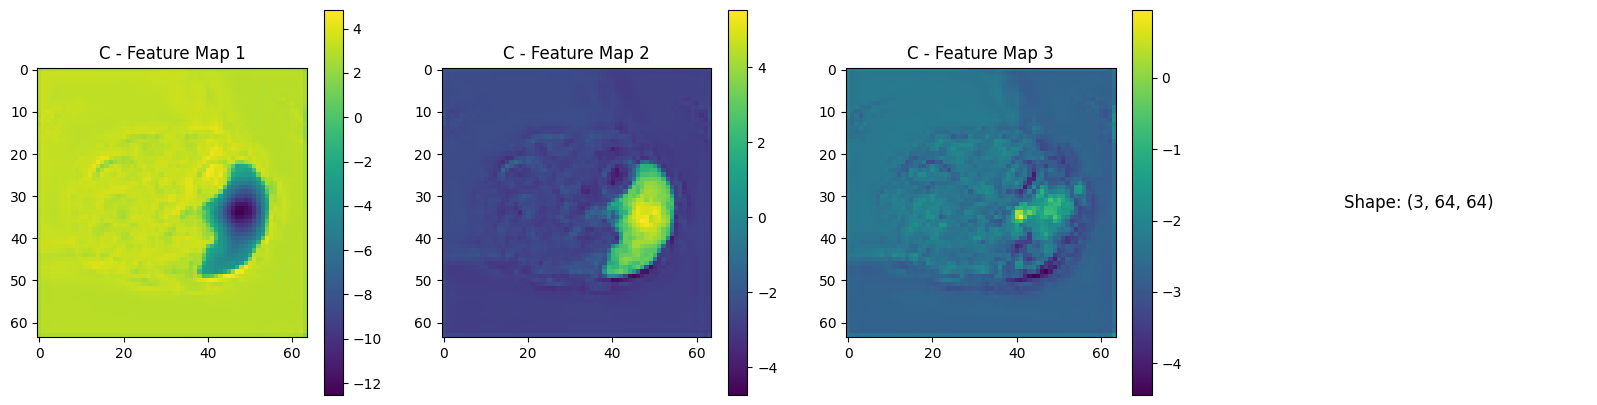

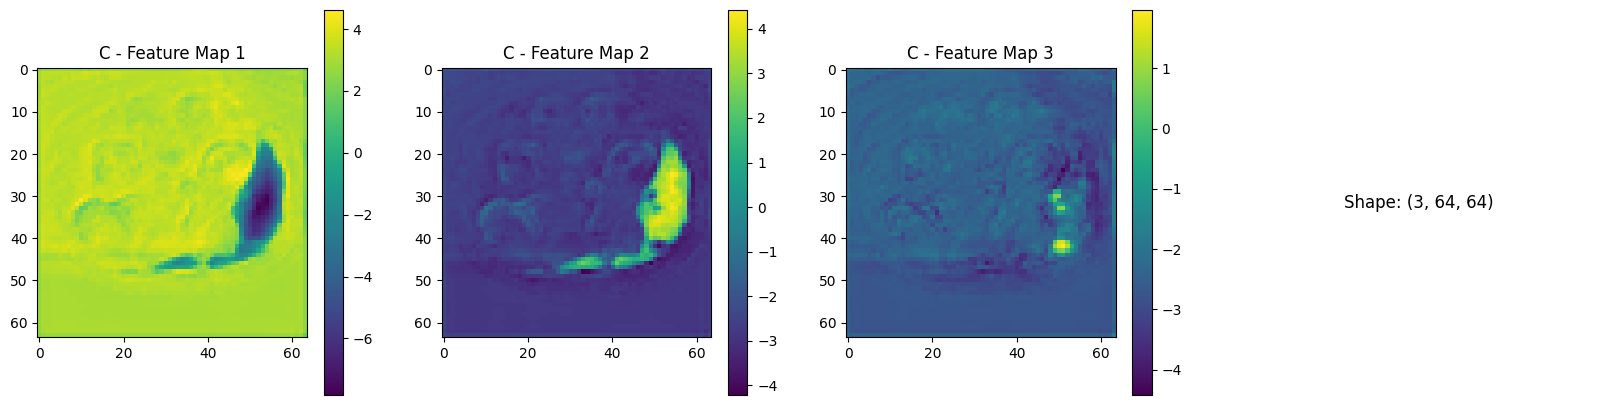

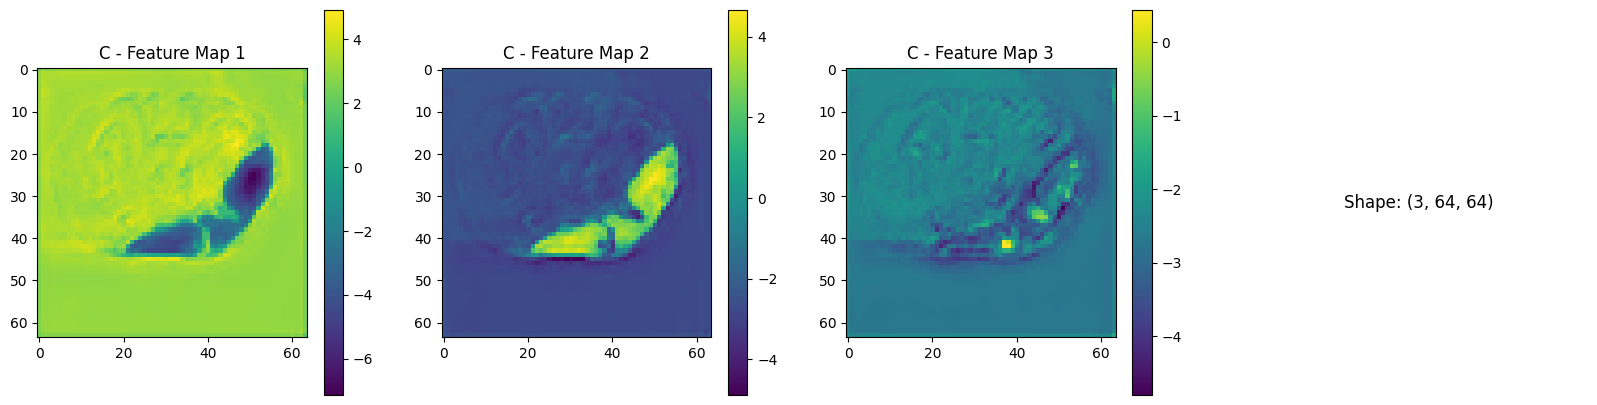

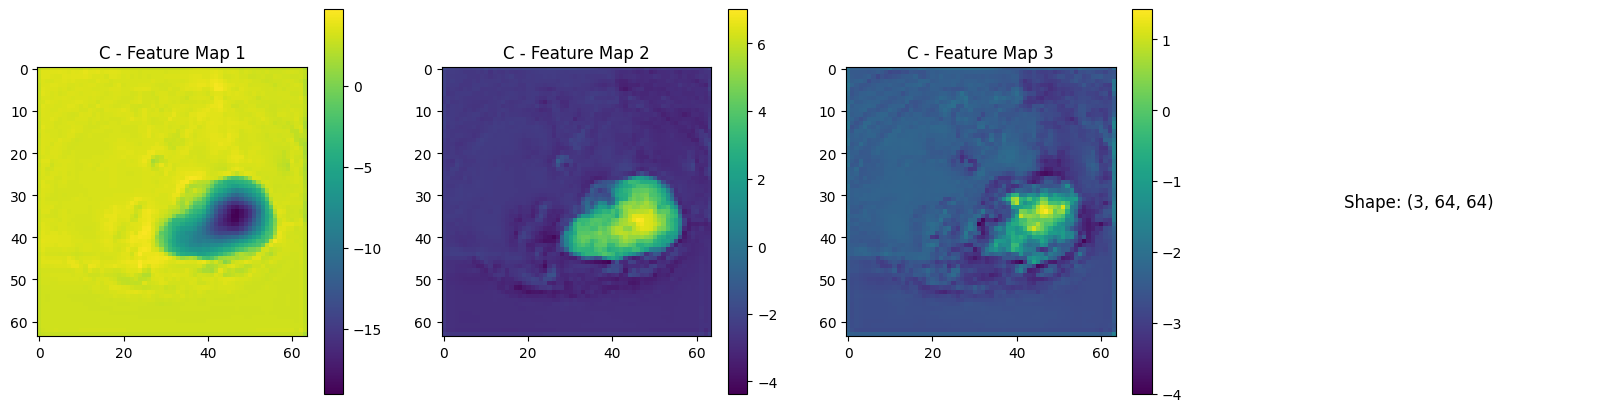

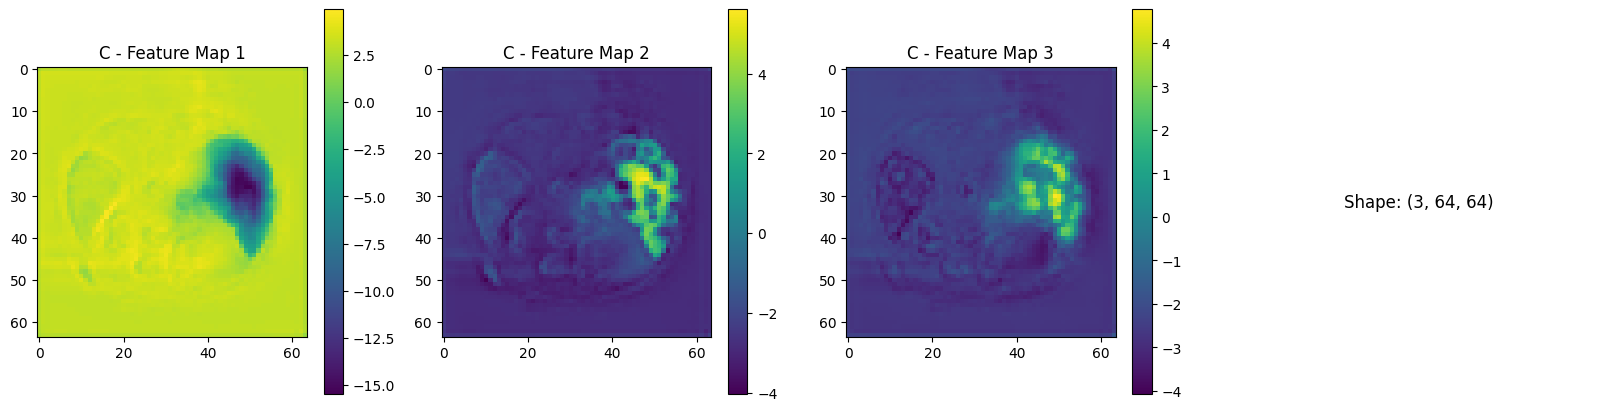

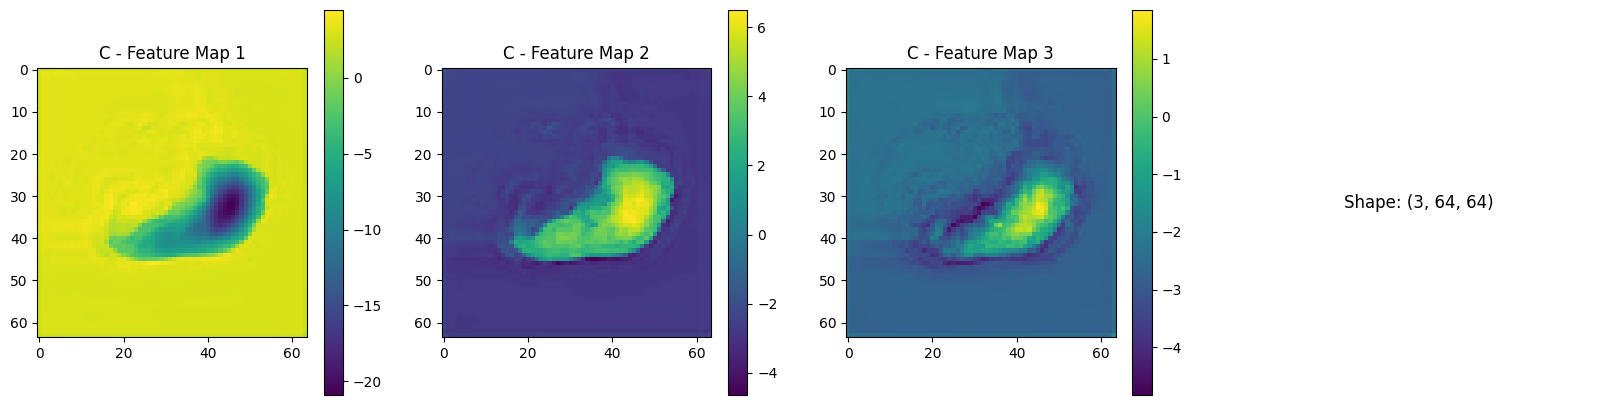

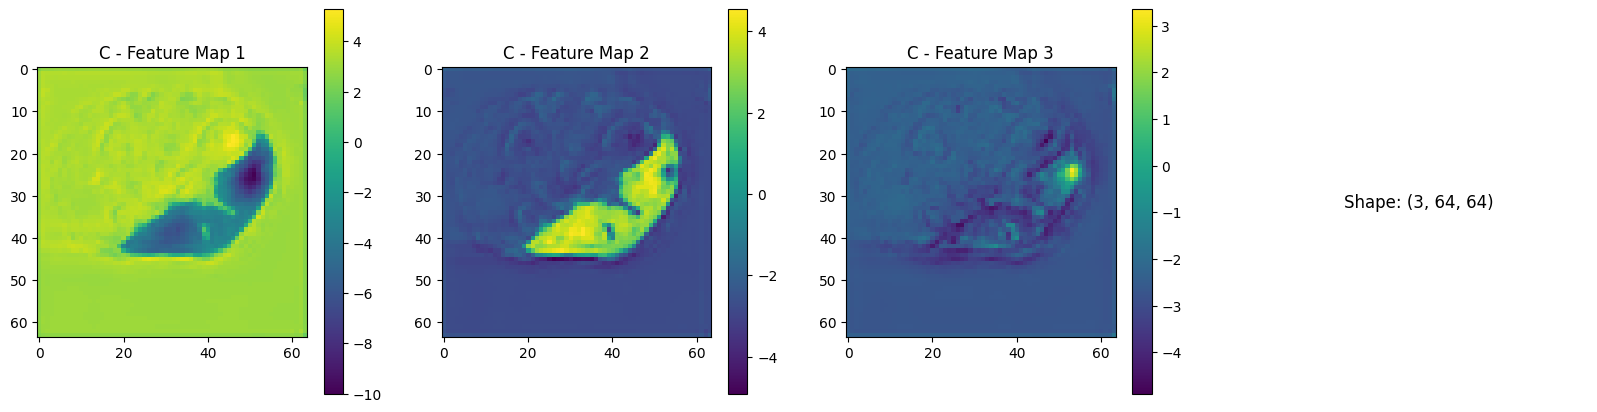

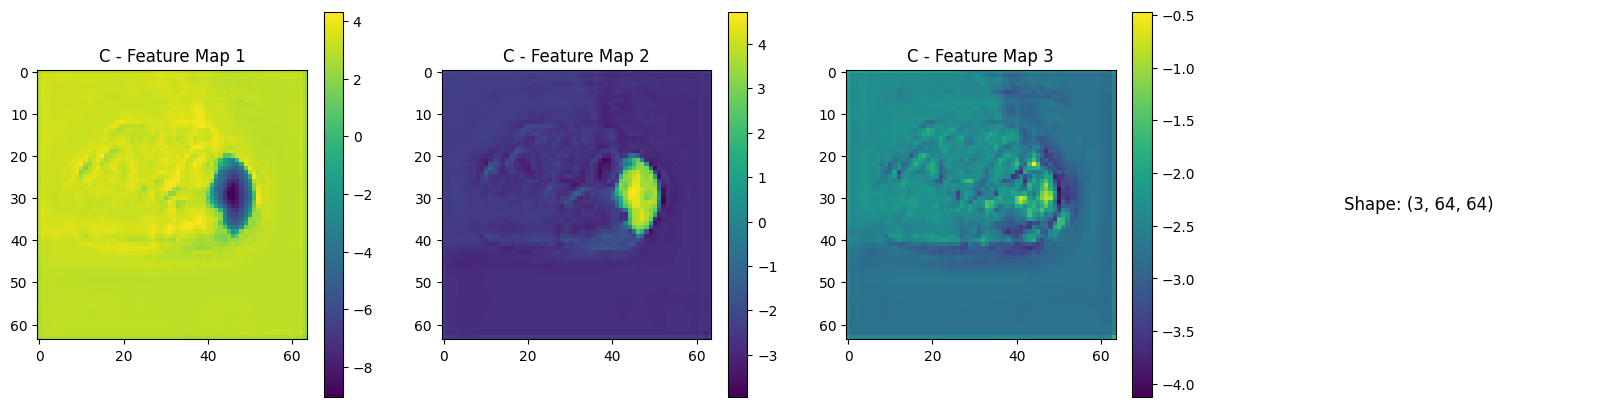

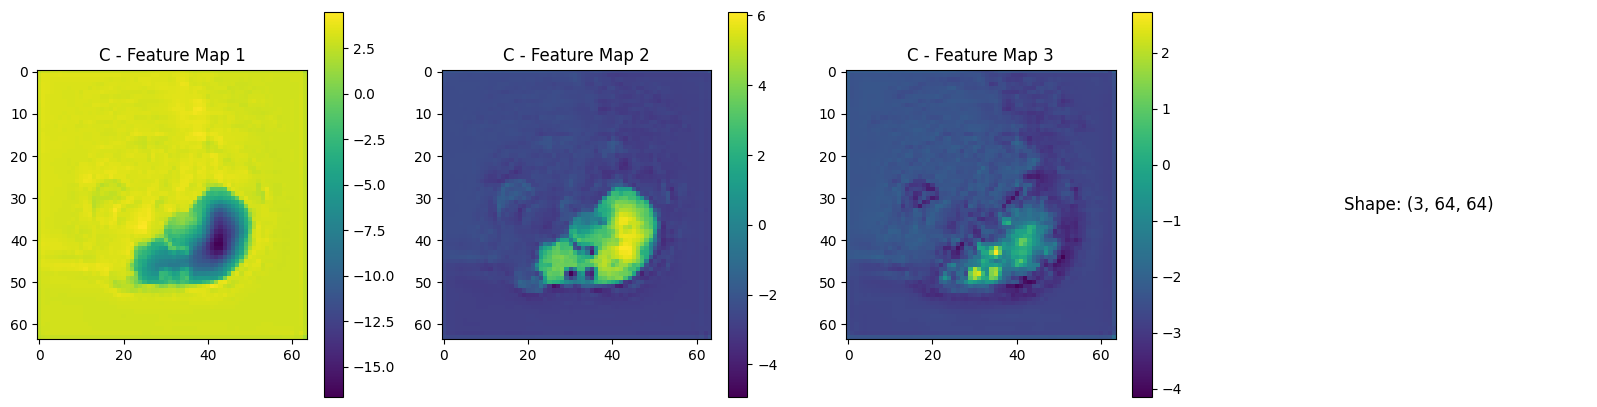

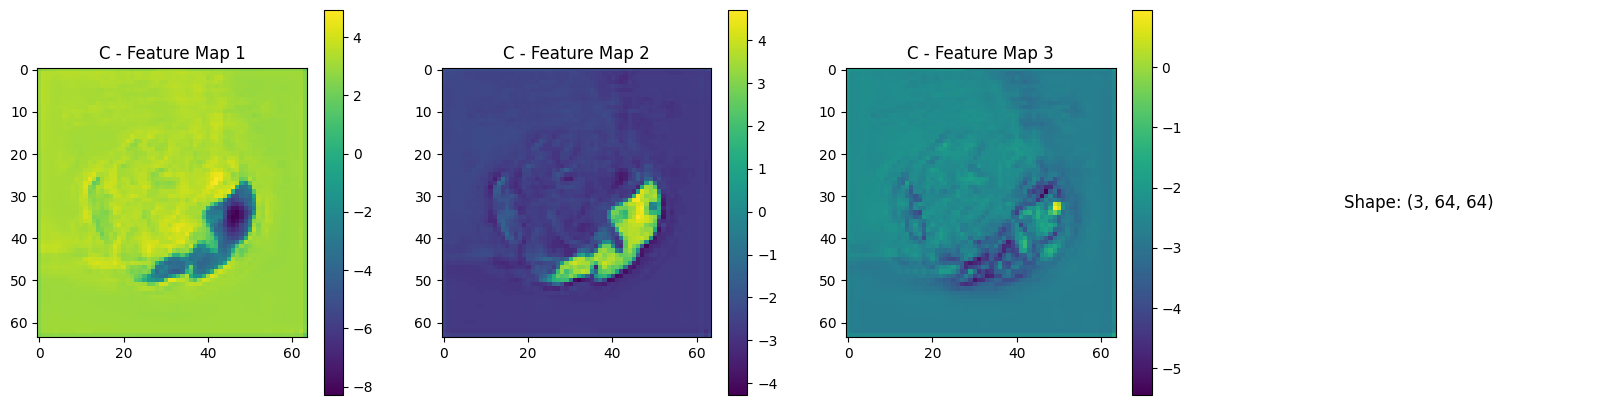

In [9]:
# Define a function to visualize feature maps
def visualize_feature_maps(dl, model, device, n_ims=15):
    cols = n_ims // 3
    rows = n_ims // cols
    count = 1
    ims, gts, preds = [], [], []

    # Iterate through the data loader
    for idx, data in enumerate(dl):
        im, gt = data
        ims.append(im)
        gts.append(gt)

        # Get predicted mask
        with torch.no_grad():
            pred = torch.argmax(model(im.to(device)), dim=1)
            preds.append(pred)

        # Visualize feature maps
        for fmap, layer_name in zip(feature_maps, layer_names):
            num_maps = fmap.shape[0]  # Get the number of feature maps in t-his layer
            num_subplots = min(num_maps, 4)  # Limit to a maximum of 4 subplots
            plt.figure(figsize=(20, 5))
            for i in range(num_subplots):  # Display up to four feature maps in one row
                plt.subplot(1, num_subplots + 1, i+1)
                plt.imshow(fmap[i], cmap='viridis')  # Display the ith feature map
                plt.title(f'{layer_name} - Feature Map {i+1}')  # Include layer name in title
                plt.colorbar()
                
            # Display the shape of processed feature maps
            plt.subplot(1, num_subplots + 1, num_subplots + 1)
            plt.text(0.5, 0.5, f'Shape: {fmap.shape}', fontsize=12, ha='center', va='center')
            plt.axis('off')
                
            plt.show()

visualize_feature_maps(test_dl, model=model, device=device)


# HeatMaps

ValueError: num must be an integer with 1 <= num <= 20, not 21

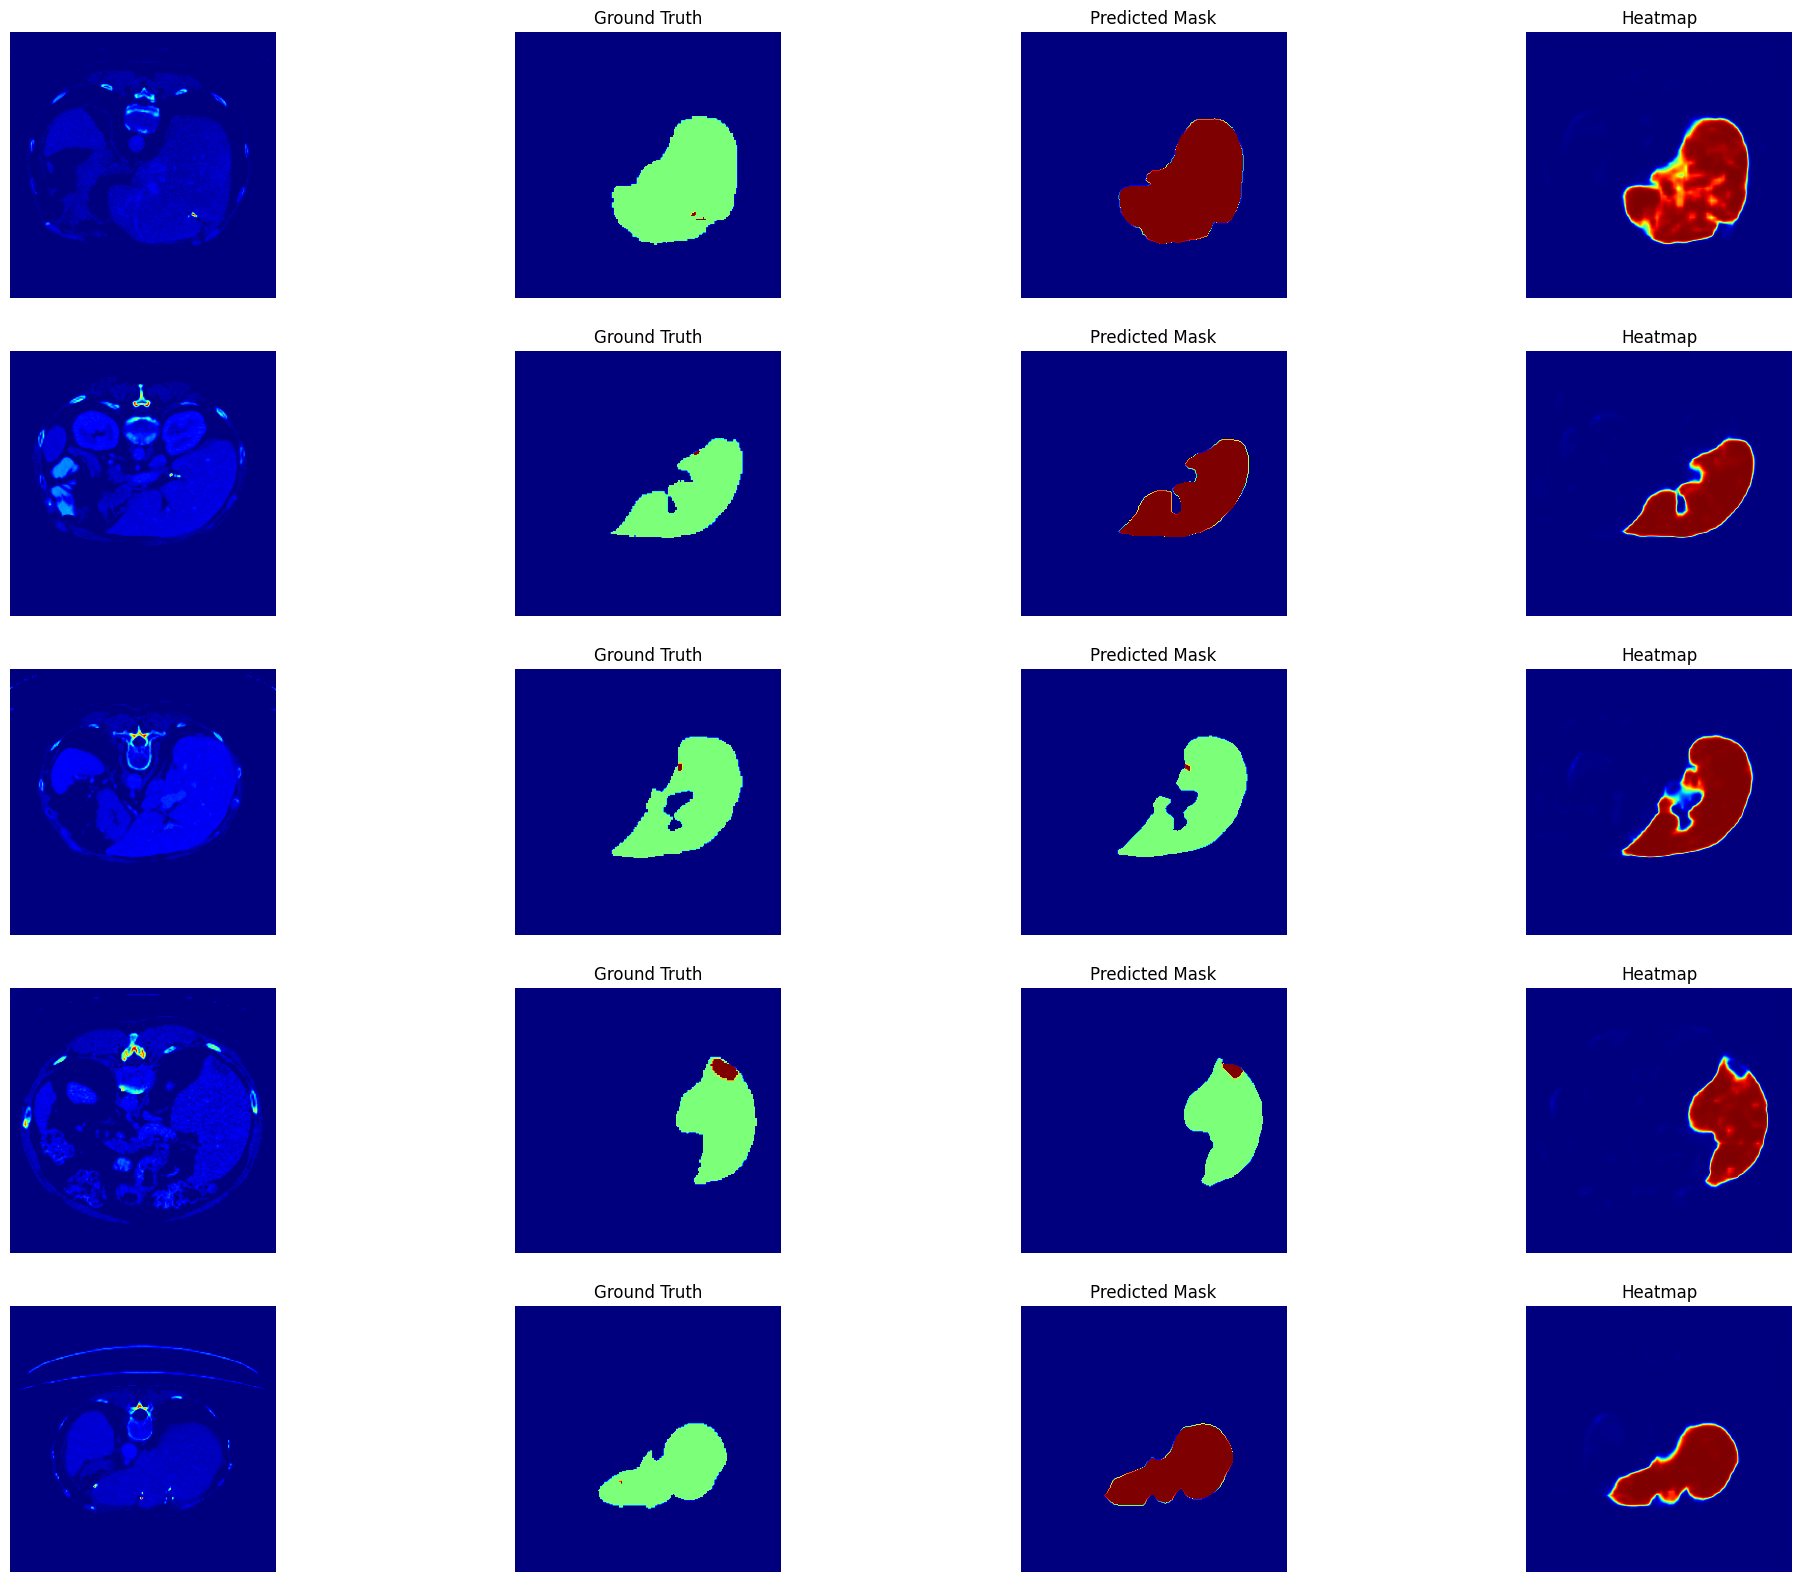

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def inference(dl, model, device, n_ims=20):
    cols = 4  # Fixed number of columns for visualization
    rows = n_ims // cols

    count = 1
    ims, gts, preds, heatmaps = [], [], [], []
    for idx, data in enumerate(dl):
        im, gt = data

        # Get predicted mask and heatmap
        with torch.no_grad():
            pred = torch.argmax(model(im.to(device)), dim=1)
            heatmap = torch.softmax(model(im.to(device)), dim=1)[:, 1, :, :]  # Assuming the model output has two channels for binary classification, and we're interested in the heatmap for the positive class
            heatmap = heatmap.cpu().detach().numpy()

        ims.append(im.cpu().numpy())
        gts.append(gt.cpu().numpy())
        preds.append(pred.cpu().numpy())
        heatmaps.append(heatmap)

    plt.figure(figsize=(25, 20))
    for idx, (im, gt, pred, heatmap) in enumerate(zip(ims, gts, preds, heatmaps)):
        if idx >= n_ims:  # Break when we reach the maximum number of images to display
            break

        # First plot
        count = plot(cols, rows, count, im.squeeze(0))

        # Second plot
        count = plot(cols, rows, count, im=gt.squeeze(0), gt=True, title="Ground Truth")

        # Third plot
        count = plot(cols, rows, count, im=pred, title="Predicted Mask")

        # Fourth plot (Heatmap)
        count = plot(cols, rows, count, im=heatmap, title="Heatmap")

def plot(cols, rows, count, im, gt=False, title=None):
    plt.subplot(rows, cols, count)
    if len(im.shape) == 3:  # If the image is a heatmap
        im = im.squeeze(0)  # Remove the batch dimension
    plt.imshow(im, cmap='jet')
    plt.axis('off')
    if title:
        plt.title(title)
    count += 1
    return count

model = torch.load("saved_models/liver_best_model.pt")
inference(test_dl, model=model, device=device)


ValueError: num must be an integer with 1 <= num <= 35, not 36

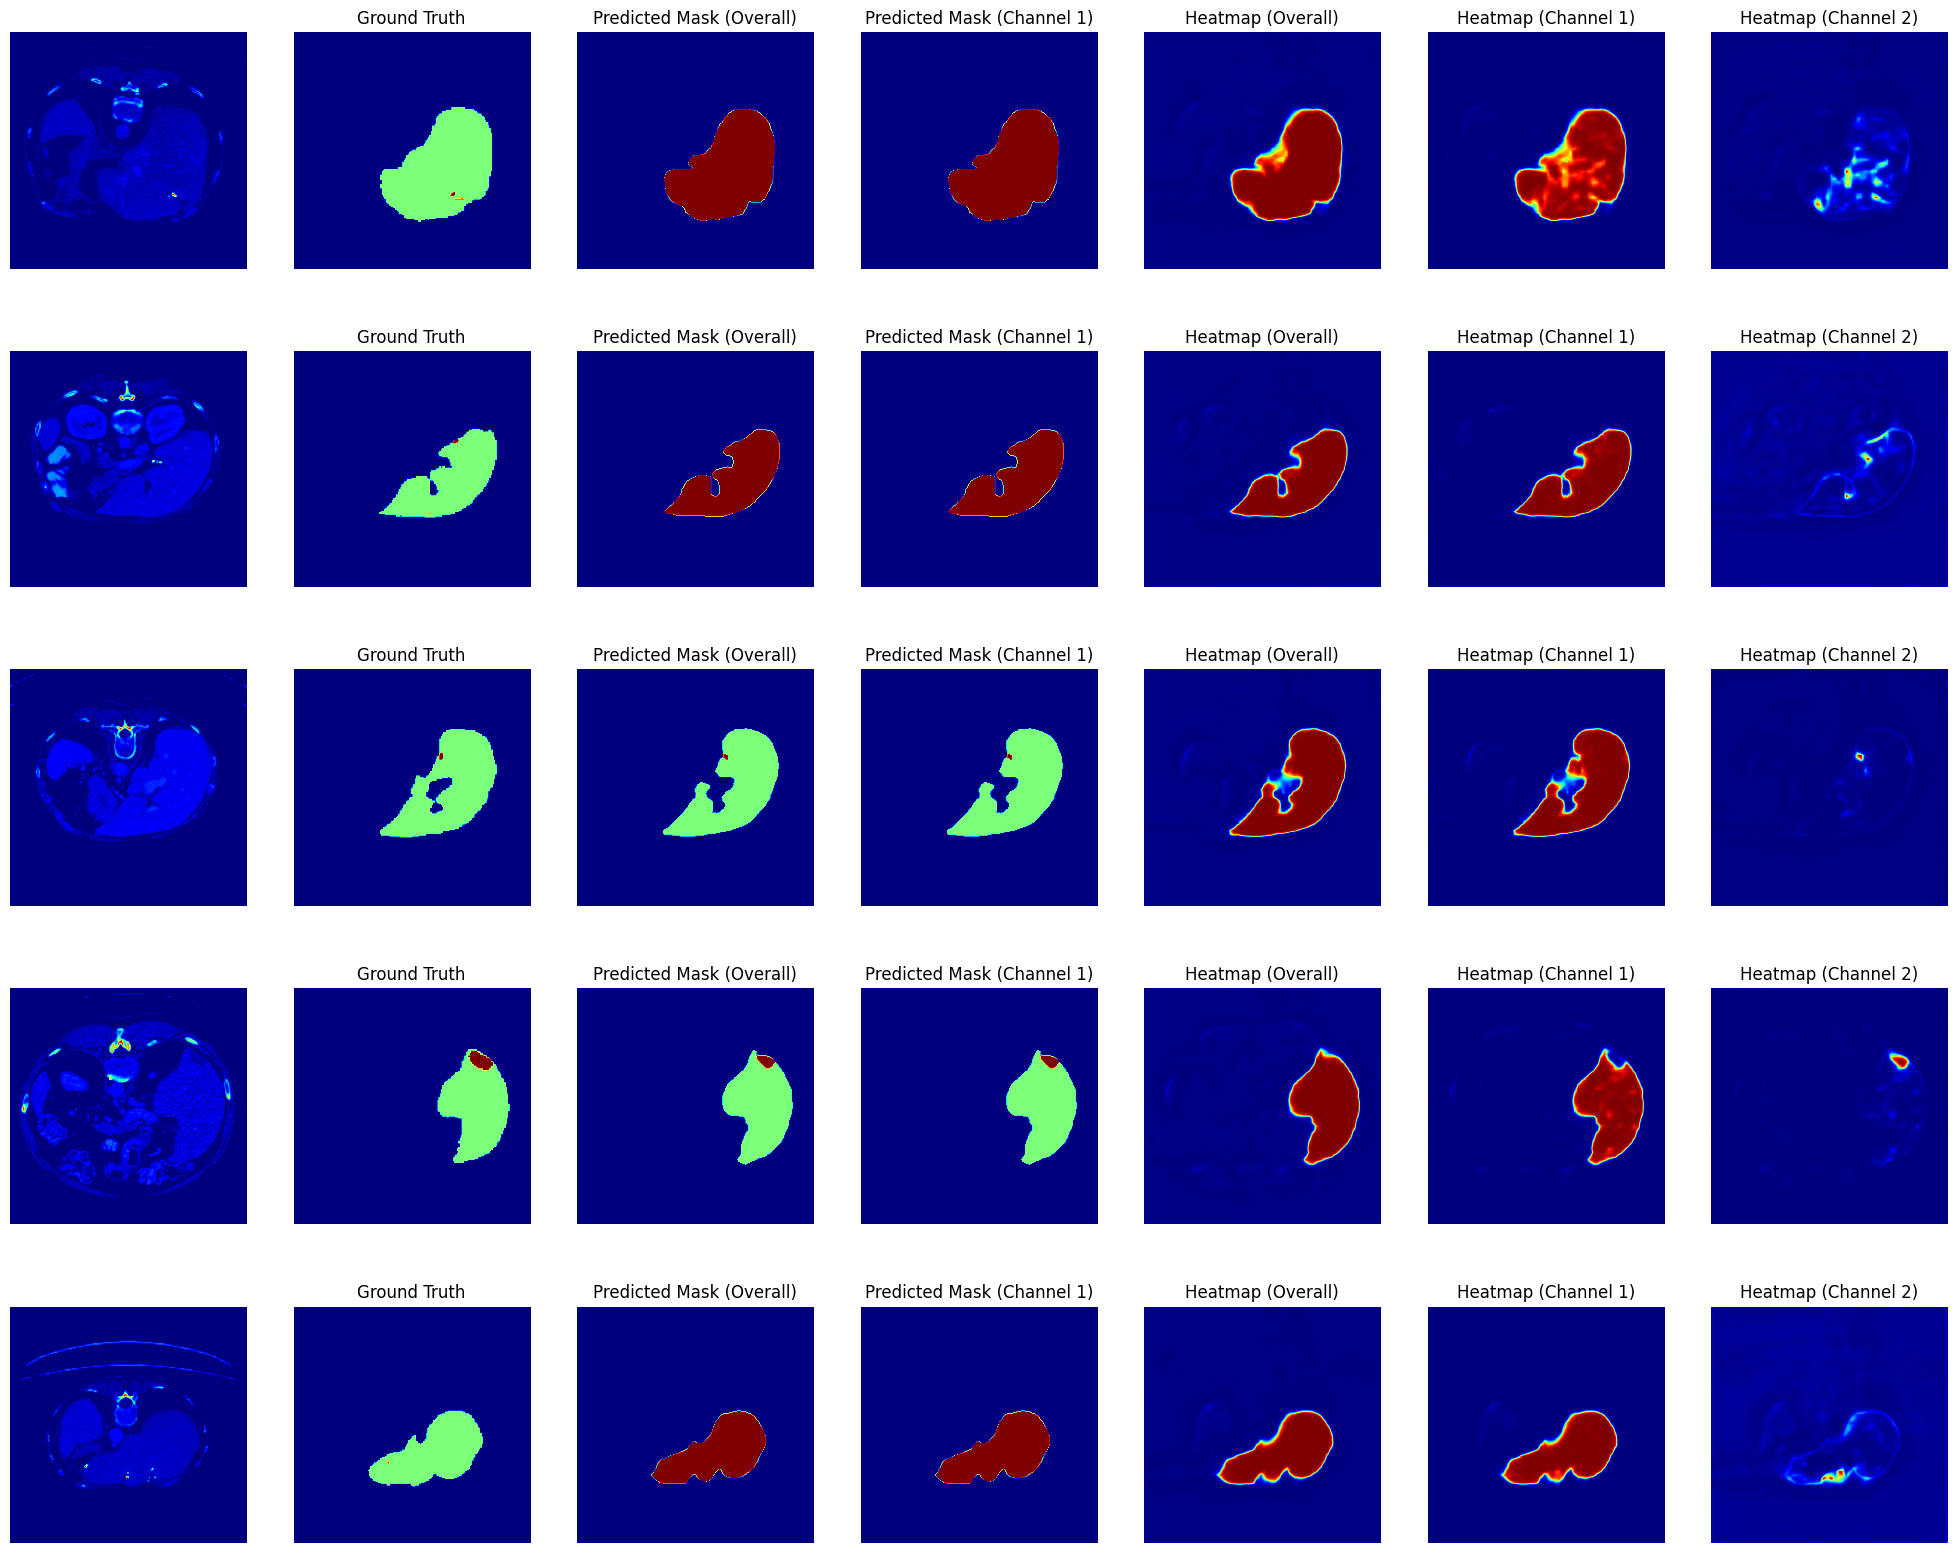

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def inference(dl, model, device, n_ims=35):
    cols = 7  # Adjust the number of columns based on the number of visualizations
    rows = n_ims // cols

    count = 1
    ims, gts, preds, heatmaps = [], [], [], []
    for idx, data in enumerate(dl):
        im, gt = data

        # Get predicted mask and heatmap
        with torch.no_grad():
            pred = model(im.to(device))
            heatmap = torch.softmax(model(im.to(device)), dim=1)[:, 1:, :, :]  # Assuming the model output has three channels (background, liver, tumor)
            pred = torch.argmax(pred, dim=1)
            pred = pred.cpu().detach().numpy()
            heatmap = heatmap.cpu().detach().numpy()

        ims.append(im.cpu().numpy())
        gts.append(gt.cpu().numpy())
        preds.append(pred)
        heatmaps.append(heatmap)

    plt.figure(figsize=(25, 20))
    for idx, (im, gt, pred, heatmap) in enumerate(zip(ims, gts, preds, heatmaps)):
        if idx >= n_ims:  # Break when we reach the maximum number of images to display
            break

        # First plot
        count = plot(cols, rows, count, im.squeeze(0))

        # Second plot
        count = plot(cols, rows, count, im=gt.squeeze(0), gt=True, title="Ground Truth")

        # Third plot
        count = plot(cols, rows, count, im=pred, title="Predicted Mask (Overall)")

        # Fourth, fifth, and sixth plots (Channels of Predicted Mask)
        for i in range(pred.shape[0]):
            count = plot(cols, rows, count, im=pred[i], title=f"Predicted Mask (Channel {i+1})")

        # Seventh plot (Overall Heatmap)
        count = plot(cols, rows, count, im=np.sum(heatmap, axis=1), title="Heatmap (Overall)")

        # Eighth, ninth, and tenth plots (Channels of Heatmap)
        for i in range(heatmap.shape[1]):
            count = plot(cols, rows, count, im=heatmap[:, i, :, :], title=f"Heatmap (Channel {i+1})")

def plot(cols, rows, count, im, gt=False, title=None):
    plt.subplot(rows, cols, count)
    if len(im.shape) == 3:  # If the image is a heatmap
        im = im.squeeze(0)  # Remove the batch dimension
    plt.imshow(im, cmap='jet')
    plt.axis('off')
    if title:
        plt.title(title)
    count += 1
    return count

model = torch.load("saved_models/liver_best_model.pt")
inference(test_dl, model=model, device=device)
